In [1]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "5"

In [2]:
from memflow.read_data.dataset_all import DatasetCombined
from memflow.unfolding_network.conditional_transformer import ConditioningTransformerLayer
from memflow.unfolding_flow.utils import *
from memflow.unfolding_flow.mmd_loss import MMD
from utils import alter_variables
from utils import alter_variables_tensor
import math

import numpy as np
import scipy.stats as st
import torch
from torch import optim
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.nn.functional import normalize
from torch.optim.lr_scheduler import CosineAnnealingLR

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib as mpl
from matplotlib import cm

from tensorboardX import SummaryWriter
from omegaconf import OmegaConf
import sys
import argparse
import os
from pynvml import *
from hist import Hist
import hist
import vector
import mplhep
import awkward as ak
import random


from memflow.read_data.utils import to_flat_tensor
from memflow.phasespace.phasespace import PhaseSpace

from utils import FindMasks
from utils import SavePlots
from utils import plot_regressionFactor

pi = torch.pi

torch.set_num_threads(10)

In [3]:
import numpy as np
import torch
import torch.nn as nn

In [4]:
channels = 5

w = np.zeros((channels, channels))

input_rank=3

print(w.shape)

print([1] * input_rank)
print(*([1] * input_rank))

w_perm = nn.Parameter(
            torch.FloatTensor(w).view(channels, channels, *([1] * input_rank)),
            requires_grad=False,
        )
print(w_perm.shape)

(5, 5)
[1, 1, 1]
1 1 1
torch.Size([5, 5, 1, 1, 1])


In [5]:
channels = 5

w = np.zeros((channels, channels))
print(np.random.permutation(channels))
for i, j in enumerate(np.random.permutation(channels)):
    w[i, j] = 1.0

print(w)

[3 4 2 0 1]
[[0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]


# Start with checking the Transformer

# For testing: The model must be always on 'eval' mode
# For testing: Never save the gradients (`.detach().cpu()`)

In [6]:
device = torch.device('cpu')

model_dir = '/eos/user/a/adpetre/www/ttHbbAnalysis/MEMFlow/models_archive/transferFlow_paperVersion-pretrained_3rdVersion_onlyExist_leptonMET_OnlyPartons_v7-3D/Transfer_Flow_Paper_pretrained_v3_MET_OnlyPartons_scaled_min5Jets=False_transfer_flow_2nd_2nd_DiagNormal_NoTransf4_NoBins30_DNN:5_512'

path_to_sample = model_dir + '/sample_few_events.pt'
path_to_sample_allEv = model_dir + '/sample_many_events.pt'
#path_to_valid = model_dir + '/valid.pt'
path_to_conf = model_dir + '/config_transfer_flow_2nd_2nd.yaml'

print(path_to_conf)

with open(path_to_conf) as f:
    config = OmegaConf.load(path_to_conf)
        
#path_data = config.input_dataset_test
path_data = config.input_dataset_validation
#print(path_data)
if config.training_params.dtype == "float32":
    dtype = torch.float32
elif config.training_params.dtype == "float64":
    dtype = torch.float64
else:
    dtype = None

/eos/user/a/adpetre/www/ttHbbAnalysis/MEMFlow/models_archive/transferFlow_paperVersion-pretrained_3rdVersion_onlyExist_leptonMET_OnlyPartons_v7-3D/Transfer_Flow_Paper_pretrained_v3_MET_OnlyPartons_scaled_min5Jets=False_transfer_flow_2nd_2nd_DiagNormal_NoTransf4_NoBins30_DNN:5_512/config_transfer_flow_2nd_2nd.yaml


In [7]:
dict_var = {
  "pt": 0,
  "eta": 1,
  "phi": 2
}

In [8]:
def sampling_print_unscaled(sampledEvent, targetEvent, plotJets, onlyExistElem=False, old_order=False):

    # plot [pt,eta,phi]
    var_name = ['pt', 'eta', 'phi']

    if onlyExistElem:
        check_target_events_withExist = targetEvent[:,plotJets,0] > -5 # here pt (not exist) 
        check_sampled_events_withExist = sampledEvent[:,plotJets,0] > -5 # here exist
        partialMaskReco = torch.logical_and(check_target_events_withExist, check_sampled_events_withExist)

    # keep objects starting from pt=0 (because it was sampled and it was saved without exist flag)
    fullGeneratedEvent_fromPt = sampledEvent[:,plotJets,0:3]   
    maskedGeneratedEvent = fullGeneratedEvent_fromPt[partialMaskReco]

    # keep objects starting from pt=1
    partial_logScaled_reco_sortedBySpanet = targetEvent[:,plotJets,0:3]
    maskedTargetEvent = partial_logScaled_reco_sortedBySpanet[partialMaskReco]
    fig, ax = plt.subplots(1, 6, figsize=(21,5), dpi=100)
    
    fig.suptitle(f'[lep, MET, tlep, thad, H]', fontsize=20)
    if old_order:
        fig.suptitle(f'[lep, MET, H, thad, tlep]', fontsize=20)

    ranges2d = [(0, 350), (-5, 5), (-3.14, 3.14)]
    ranges1d = [(-300, 300), (-5, 5), (-3.14, 3.14)]

    if plotJets == 0:
        title = 'lepton'
    elif plotJets == 1:
        title = 'MET'
    else:
        title = f'jet = {plotJets}'

    # check pt,eta,phi distrib
    for plot_var in range(3):

        diff_generatedAndTarget = (maskedGeneratedEvent[:,plot_var] - maskedTargetEvent[:,plot_var])
        ax[2*plot_var].hist(diff_generatedAndTarget.detach().cpu().numpy(), range=ranges1d[plot_var], bins=20, histtype='step', color='b', stacked=False, fill=False)
        ax[2*plot_var].set_xlabel(f'{var_name[plot_var]}_generated - {var_name[plot_var]}_target')
        ax[2*plot_var].set_title(f'{title}')

        h = ax[2*plot_var + 1].hist2d(maskedGeneratedEvent[:,plot_var].detach().cpu().numpy(),
                      maskedTargetEvent[:,plot_var].detach().cpu().numpy(),
                      bins=100, range=[ranges2d[plot_var],ranges2d[plot_var]], cmin=1)
        fig.colorbar(h[3], ax=ax[2*plot_var + 1])
        ax[2*plot_var + 1].set_xlabel(f'sampled {var_name[plot_var]}')
        ax[2*plot_var + 1].set_ylabel(f'target {var_name[plot_var]}')
        ax[2*plot_var + 1].set_title(f'{title}')

    fig.tight_layout()

In [9]:
def sampling_print_oneEvent_oneVar(sampledEvent, targetEvent,
                                   evNo, var='pt', noObjs=12, range_x=(0,600), difference=False, old_order=False):
    
    no_rows = int(noObjs / 4) 
    fig, axs = plt.subplots(no_rows, 4, figsize=(25, 4*no_rows))
    fig.suptitle(f'Ev = {evNo} \n [lep, MET, tlep, thad, H]', fontsize=20)
    if old_order:
        fig.suptitle(f'Ev = {evNo} \n [lep, MET, H, thad, tlep]', fontsize=20)

    for i in range(no_rows):    
        for j in range(4):
            if 4*i+j == 0:
                title = 'lepton'
            elif 4*i+j == 1:
                title = 'MET'
            else:
                title = f'jet {4*i+j}'
        
            if difference:
                axs[i][j].hist(sampledEvent[evNo, :, 4*i+j, dict_var[var]].numpy() - targetEvent[evNo, 4*i+j, dict_var[var]].numpy(),
                               bins=100, range=range_x, label="difference");
            else:
                axs[i][j].hist(sampledEvent[evNo, :, 4*i+j, dict_var[var]].numpy(), bins=100, range=range_x, label="Sampled");
                axs[i][j].axvline(targetEvent[evNo, 4*i+j, dict_var[var]].numpy(), c="red", label="Truth")
            axs[i][j].set_xlabel(f"{title} {var}", fontsize=12)
            axs[i][j].legend()
    fig.tight_layout()

In [10]:
def sampling_print_oneEvent_2Dcorr(sampledEvent, targetEvent, evNo, jetNo, var='pt',
                                   noObjs=12, range_x=(0, 600), xlabel='x', ylabel='y', old_order=False):
    
    fig, axs = plt.subplots(9, 4, figsize=(25, 40))
    fig.suptitle(f'Ev = {evNo} \n [lep, MET, tlep, thad, H]', fontsize=20)
    if old_order:
        fig.suptitle(f'Ev = {evNo} \n [lep, MET, H, thad, tlep]', fontsize=20)

    if jetNo == 0:
        title = 'lepton'
    elif jetNo == 1:
        title = 'MET'
    else:
        title = f'jet {jetNo}'

    for i in range(9):
        for j in range(4):
            var2 = (4*i + j) % 3
            jetNo2 = int((4*i + j) / 3)

            if jetNo2 == 0:
                title2 = 'lepton'
            elif jetNo2 == 1:
                title2 = 'MET'
            else:
                title2 = f'jet {jetNo2}'

            if var2 == 0:
                minVal=0
                maxVal=600
            else:
                minVal = -3
                maxVal = 3

            
            axs[i][j].hist2d(sampledEvent[evNo, :, jetNo, dict_var[var]].numpy(),
                             sampledEvent[evNo, :, jetNo2, var2].numpy(),                          
                             bins=1000, range=[range_x, (minVal, maxVal)], cmin=1, cmap="viridis");
            
            axs[i][j].plot(targetEvent[evNo, jetNo, dict_var[var]].numpy(),
                              targetEvent[evNo, jetNo2, var2].numpy(),
                              'rx', label="Truth")
            
            axs[i][j].set_xlabel(f"{title} {var}", fontsize=12)
            axs[i][j].set_ylabel(f"{title2} {list(dict_var.keys())[var2]}", fontsize=12)
            axs[i][j].legend()

    fig.tight_layout()

In [11]:
def sampling_print_manyEvents__oneJet_oneVar(sampledEvent, targetEvent, listEv, jetNo,
                                               var='pt', noObjs=12, range_x=(0,600), difference=False, old_order=False):

    no_rows = int(len(listEv) / 4) + 1
    fig, axs = plt.subplots(no_rows, 4, figsize=(25, 4*no_rows))
    fig.suptitle(f'[lep, MET, tlep, thad, H]', fontsize=20)
    if old_order:
        fig.suptitle(f'[lep, MET, H, thad, tlep]', fontsize=20)

    for i in range(no_rows):
        for j in range(4):
            if 4*i + j >= len(listEv):
                break
            evNo = listEv[4*i + j]
            if difference:
                axs[i][j].hist(sampledEvent[evNo, :, jetNo, dict_var[var]].numpy() - targetEvent[evNo, jetNo, dict_var[var]].numpy(),
                               bins=100, range=range_x, label="difference");
            else:
                axs[i][j].hist(sampledEvent[evNo, :, jetNo, dict_var[var]].numpy(), bins=100, range=range_x, label="Sampled");
                axs[i][j].axvline(targetEvent[evNo, jetNo, dict_var[var]].numpy(), c="red", label="Truth")
            axs[i][j].set_xlabel(f"Jet {jetNo} {var}", fontsize=12)
            axs[i][j].legend()
    fig.tight_layout()

In [12]:
def sampling_print_manyEvents__oneJet_allVar(sampledEvent, targetEvent, listEv, jetNo,
                                             range_x=[(0,600), (-3,3), (-3,3)], noObjs=12, difference=False, old_order=False):

    no_rows = len(listEv)
    fig, axs = plt.subplots(no_rows, 3, figsize=(25, 4*no_rows))
    fig.suptitle(f'[lep, MET, tlep, thad, H]', fontsize=20)
    if old_order:
        fig.suptitle(f'[lep, MET, H, thad, tlep]', fontsize=20)

    

    for i in range(no_rows):
        for j in range(3):
            evNo = listEv[i]

            if difference:
                axs[i][j].hist(sampledEvent[evNo, :, jetNo, j].numpy() - targetEvent[evNo, jetNo, j].numpy(),
                               bins=100, range=range_x[j], label="difference");
            else:
                axs[i][j].hist(sampledEvent[evNo, :, jetNo, j].numpy(), bins=100, range=range_x[j], label="Sampled");
                axs[i][j].axvline(targetEvent[evNo, jetNo, j].numpy(), c="red", label="Truth")
            axs[i][j].set_xlabel(f"Jet {jetNo} {list(dict_var.keys())[j]}", fontsize=12)
            axs[i][j].legend()
    fig.tight_layout()

In [13]:
def unscale_var(log_mean_reco, log_std_reco, scaled_target):
    # exist on first position
    unscaled_target = torch.clone(scaled_target) # keep the same exist=1
    
    unscaled_target[:,:,1:4] = scaled_target[:,:,1:4]*log_std_reco + log_mean_reco
    unscaled_target[:,:,1] = torch.exp(unscaled_target[:,:,1]) - 1 # unscale pt

    mask_nonExist = (scaled_target[...,0] == 0).unsqueeze(dim=2)
    unscaled_target[...,1:4] = torch.where(mask_nonExist, -5, unscaled_target[...,1:4])

    return unscaled_target

# First VALID - ORDRING IMPORTANT

In [86]:
sampledValid = torch.load(path_to_valid, map_location=device)
 
print(sampledValid.shape)


torch.Size([178176, 6, 12, 3])


In [20]:
for i in range(12):
    sampling_print_unscaled(sampledValid[:,1], sampledValid[:,0], plotJets=i, onlyExistElem=True)

NameError: name 'sampledValid' is not defined

# ORDERING IMPORTANT

In [11]:
sampledEvent = torch.load(path_to_sample, map_location=device)
sampledAllEvent = torch.load(path_to_sample_allEv, map_location=device)

print(sampledEvent.shape)
print(sampledAllEvent.shape)

torch.Size([52, 20001, 12, 3])
torch.Size([1792000, 31, 12, 3])


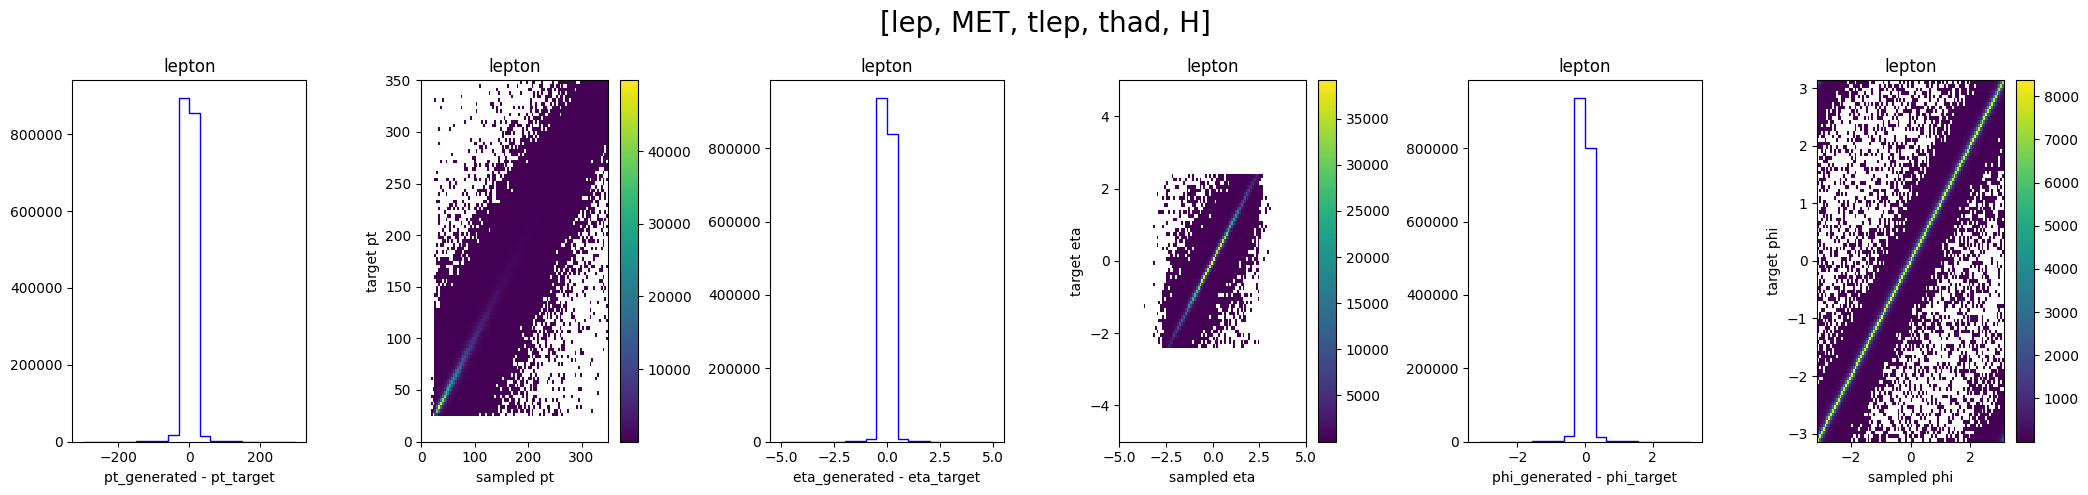

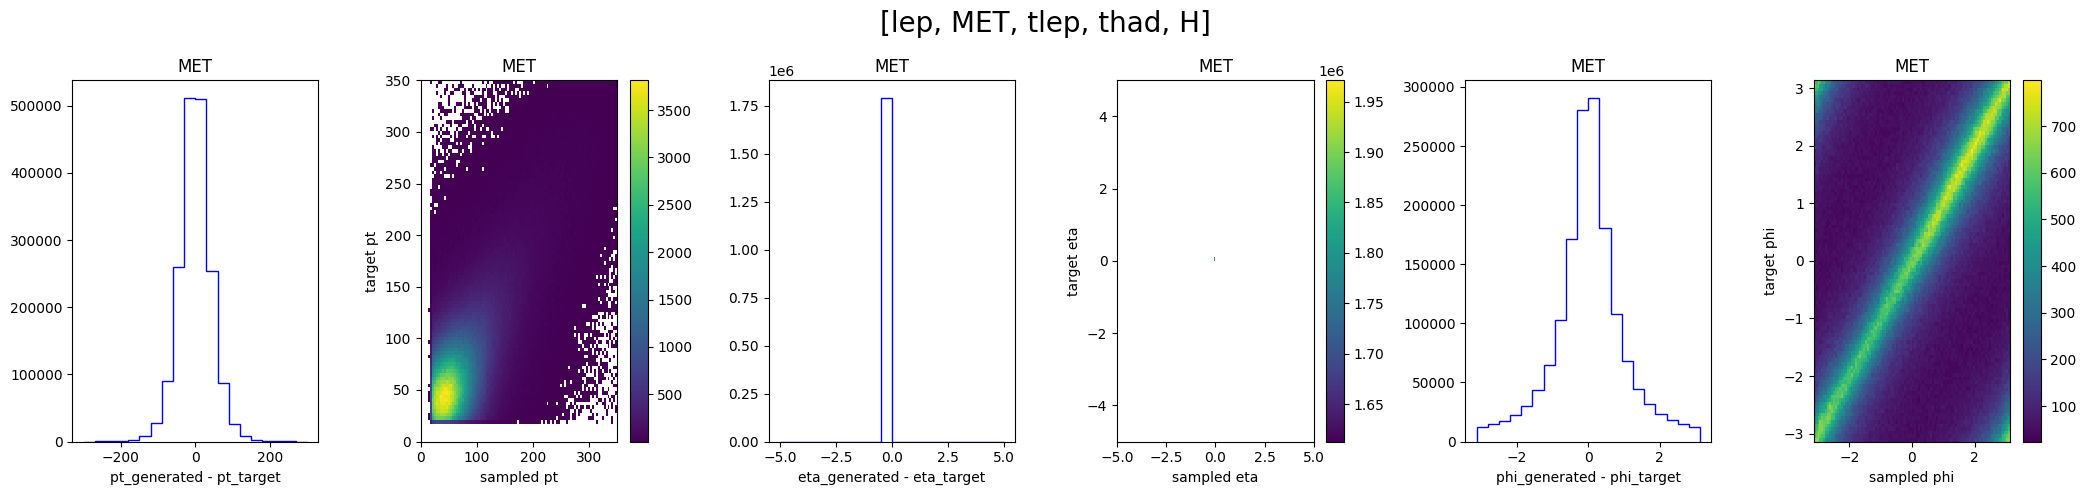

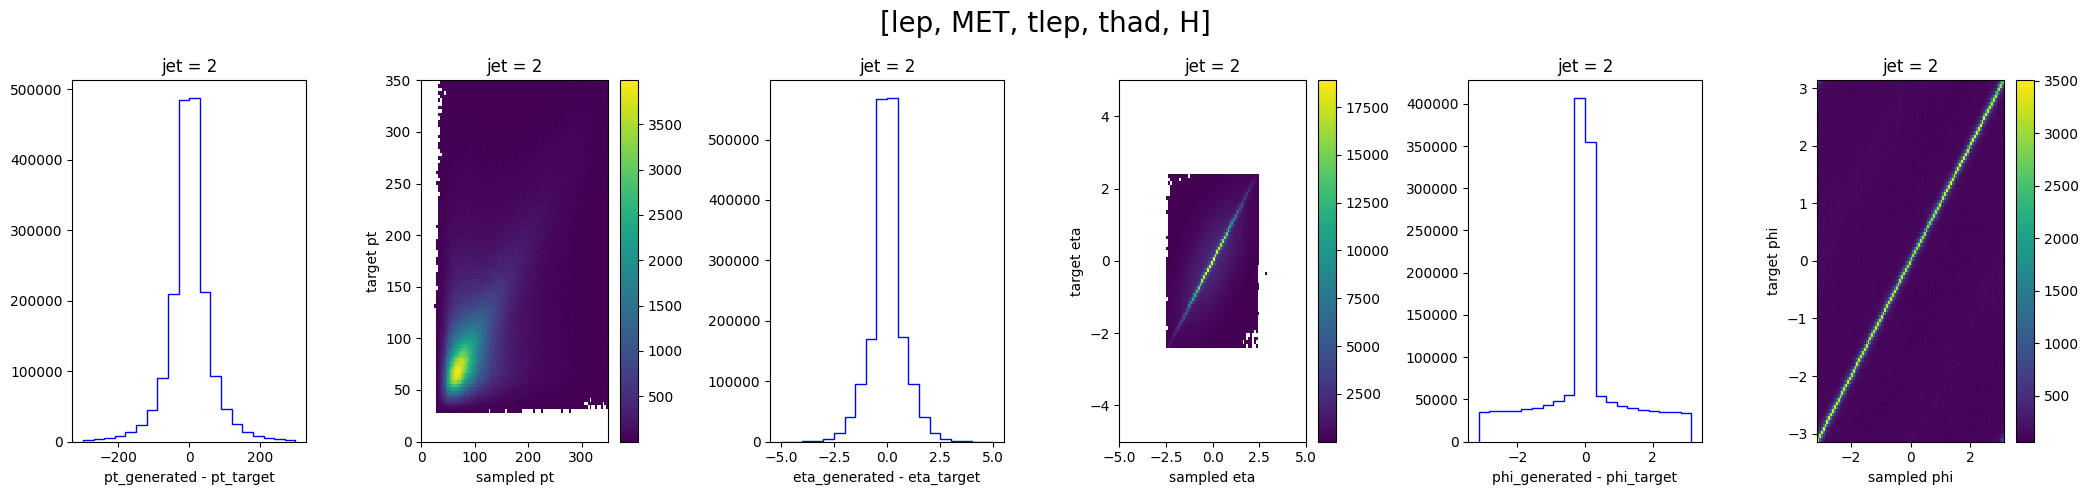

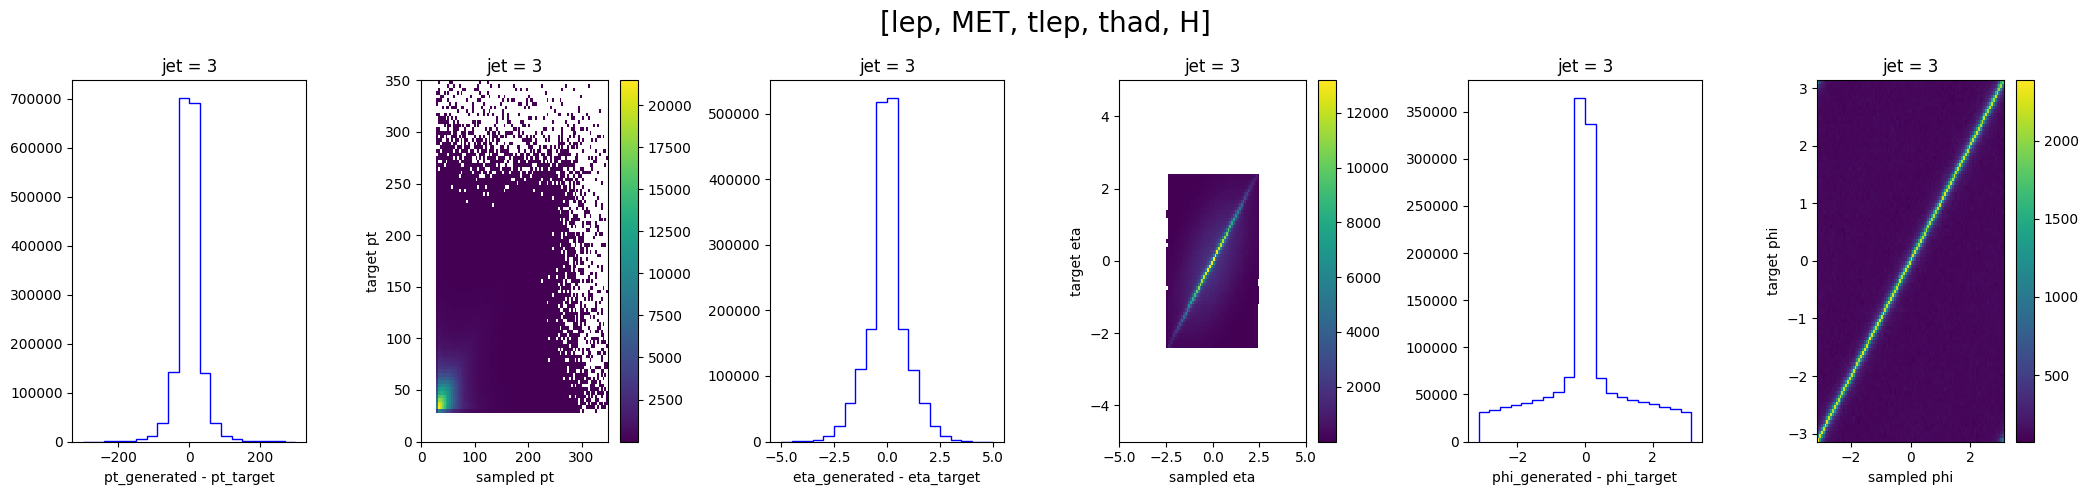

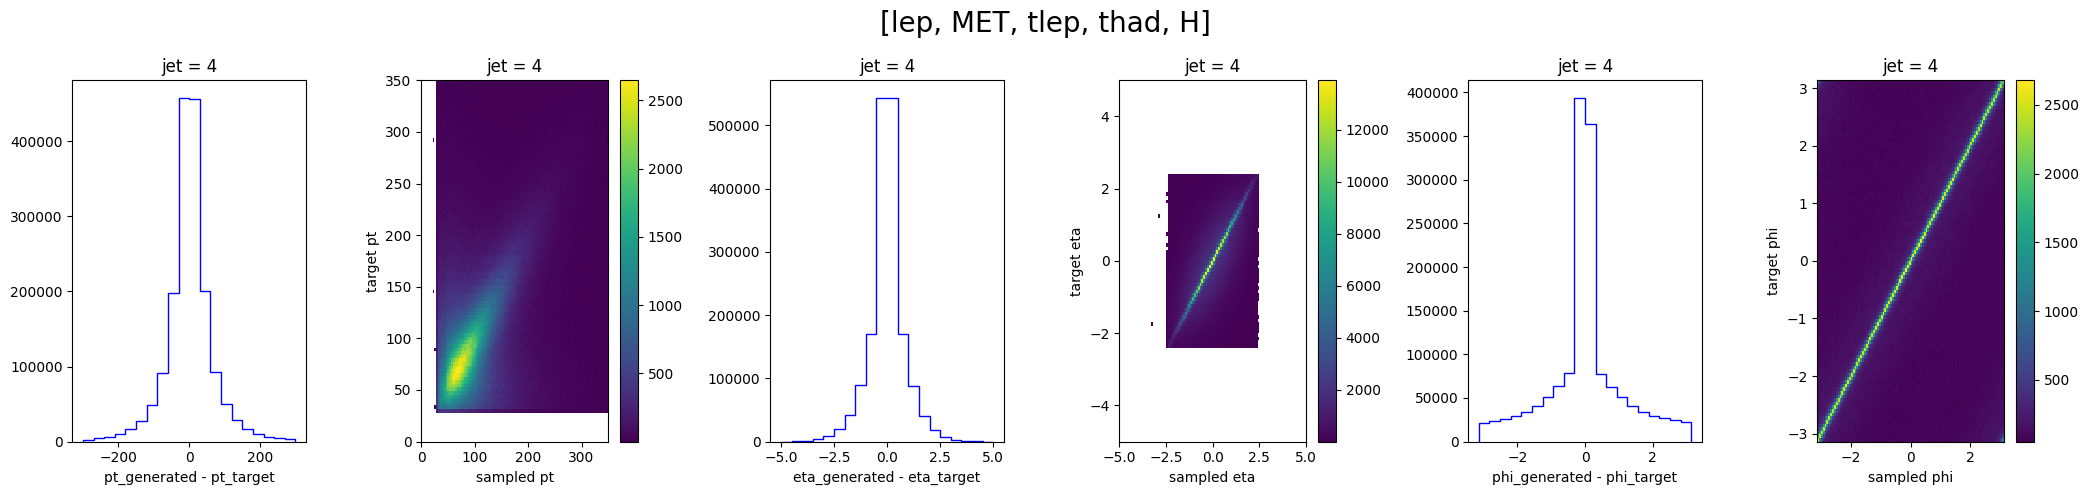

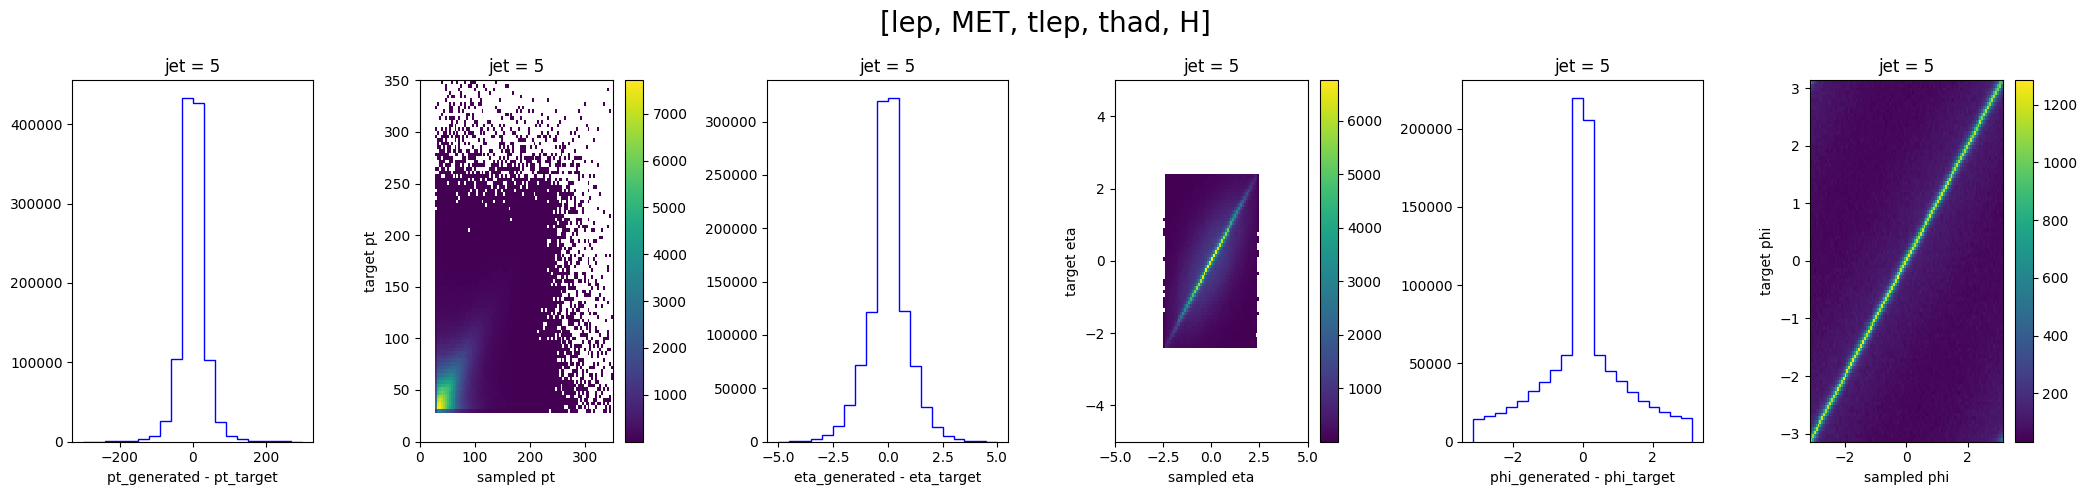

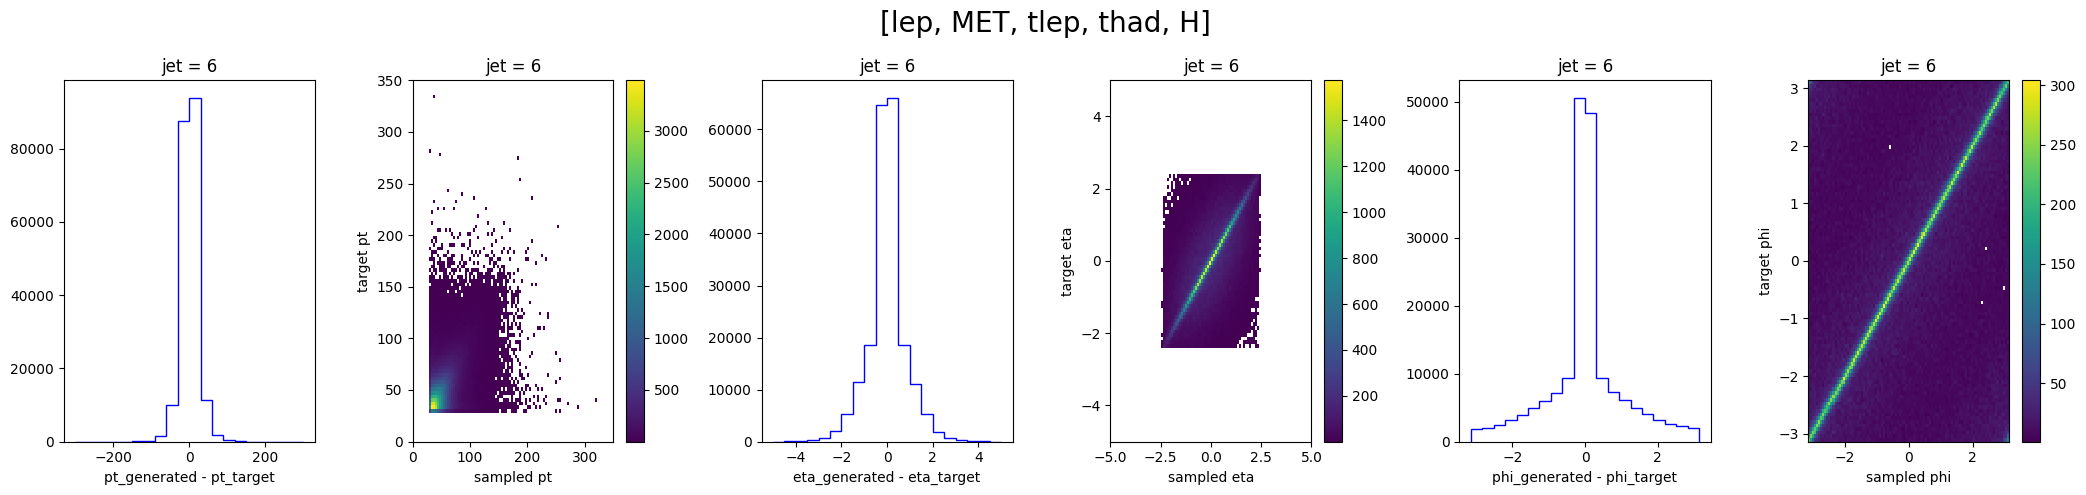

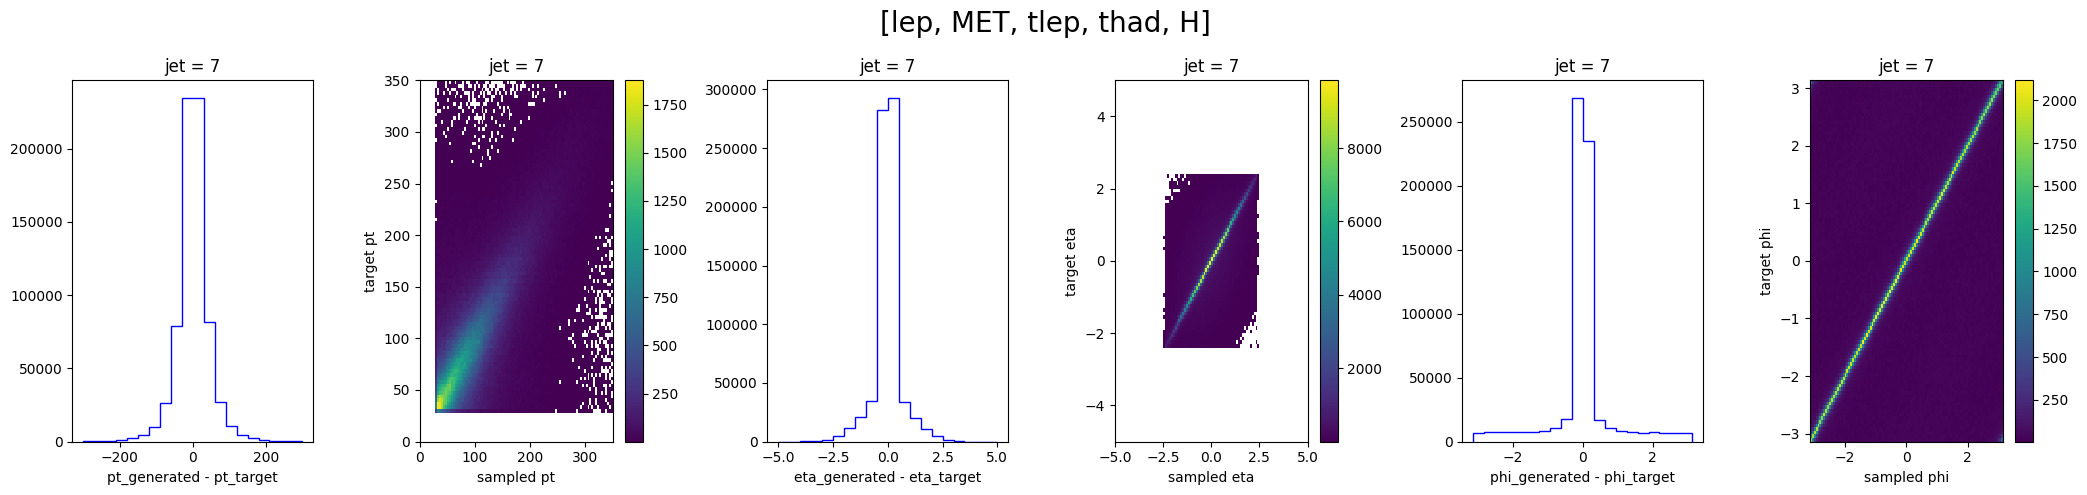

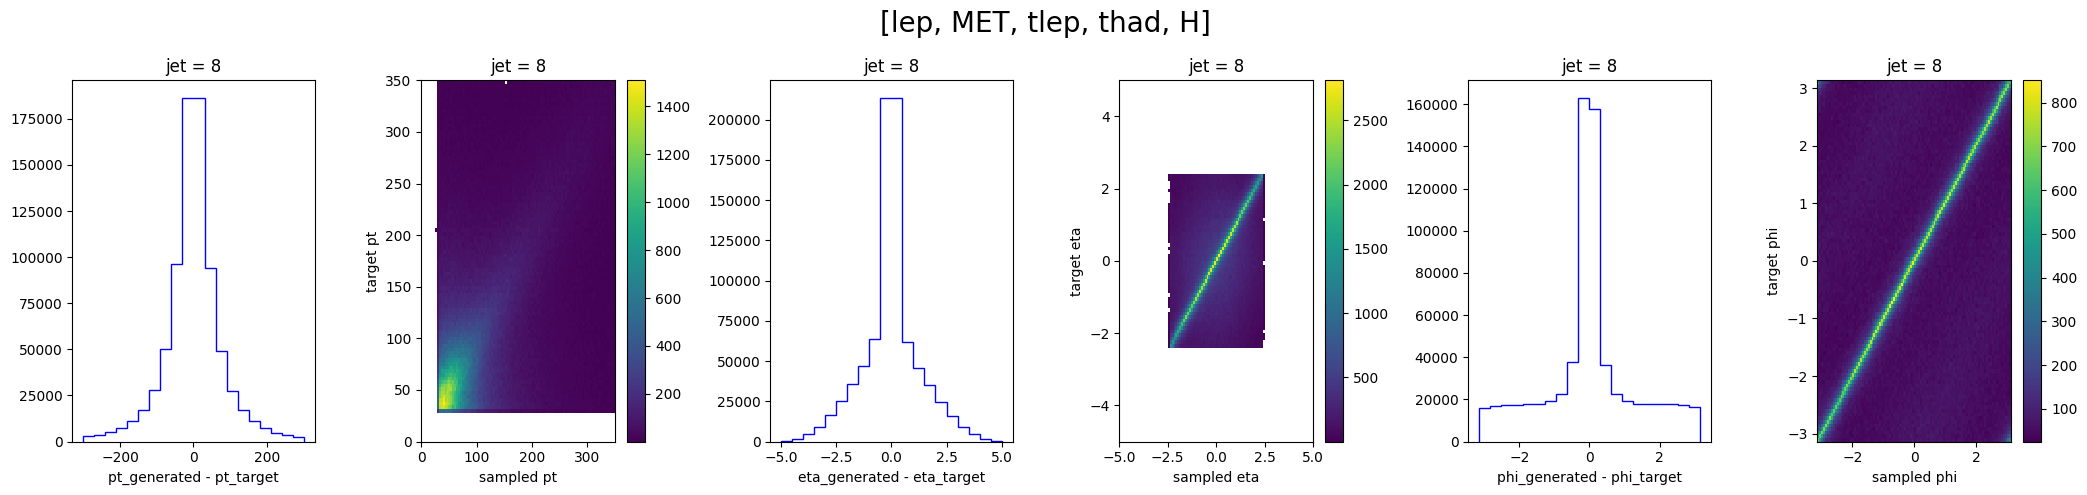

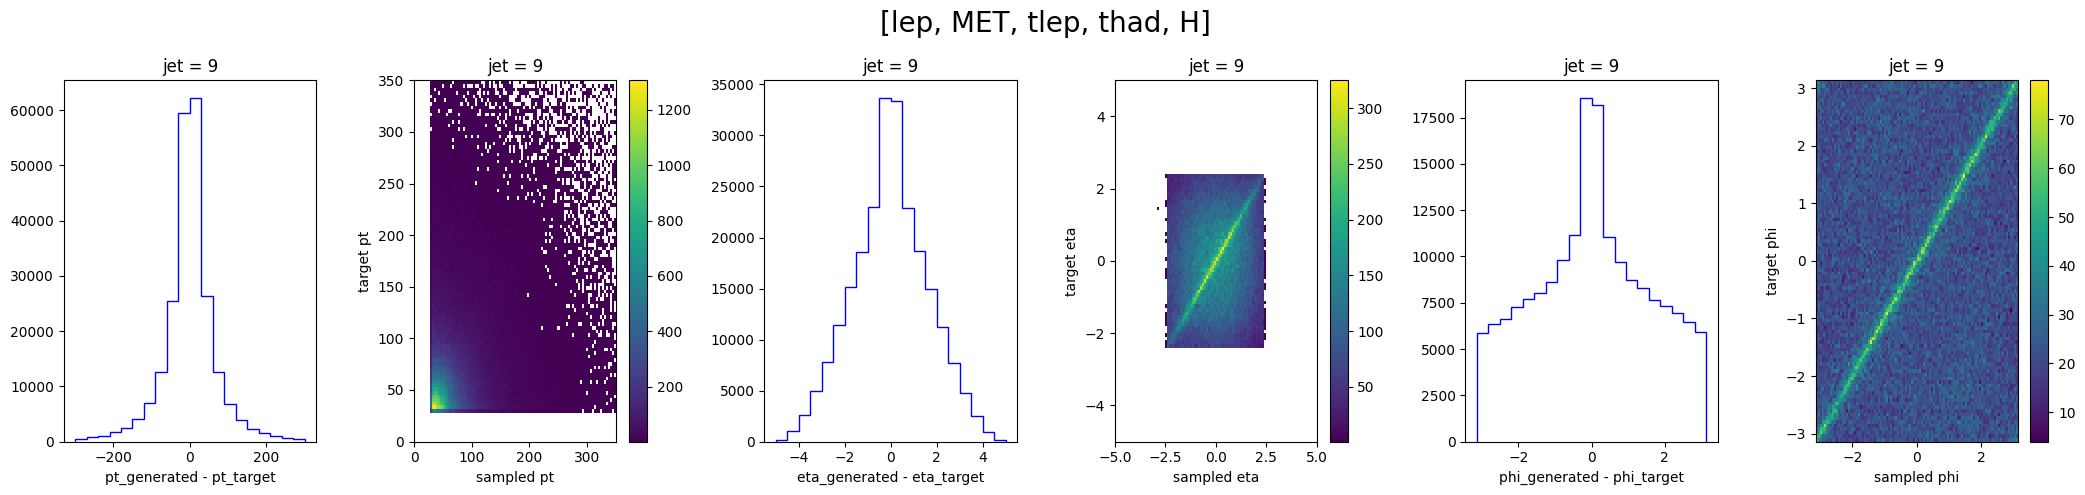

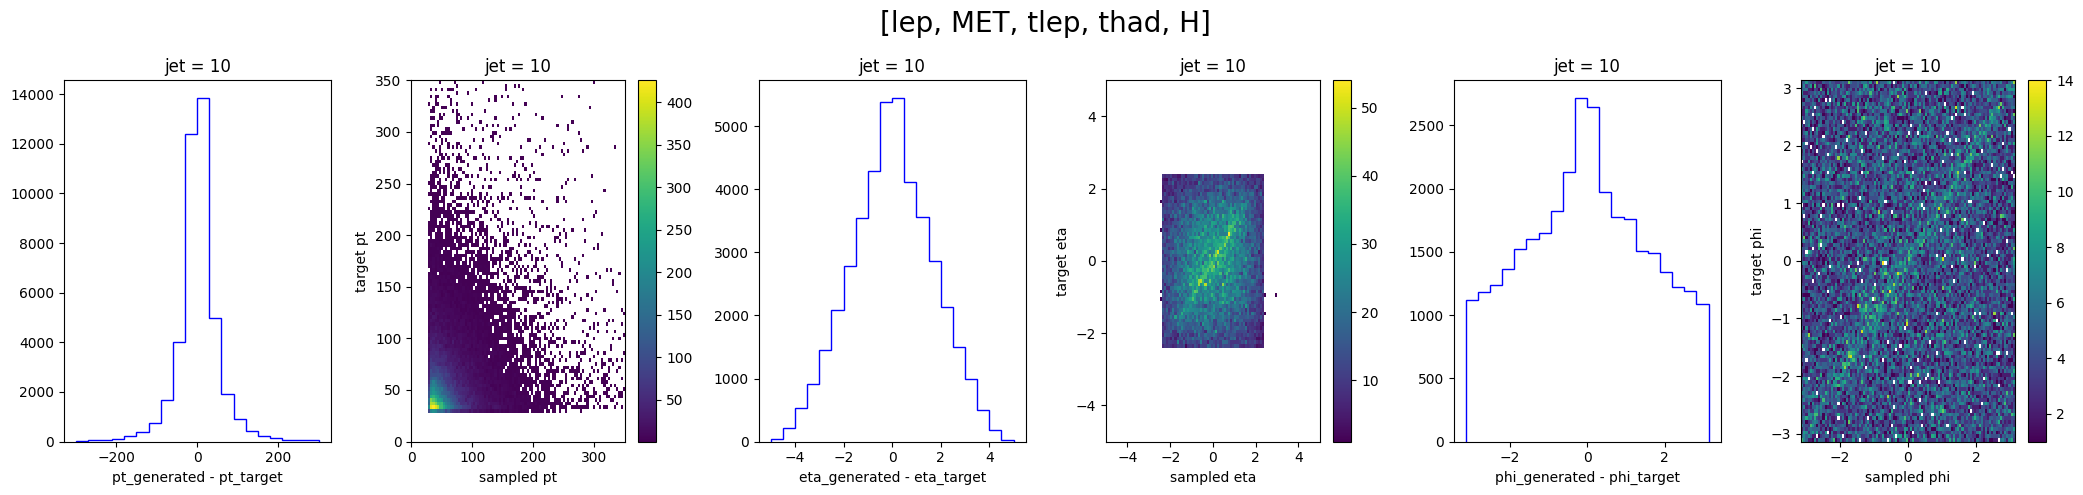

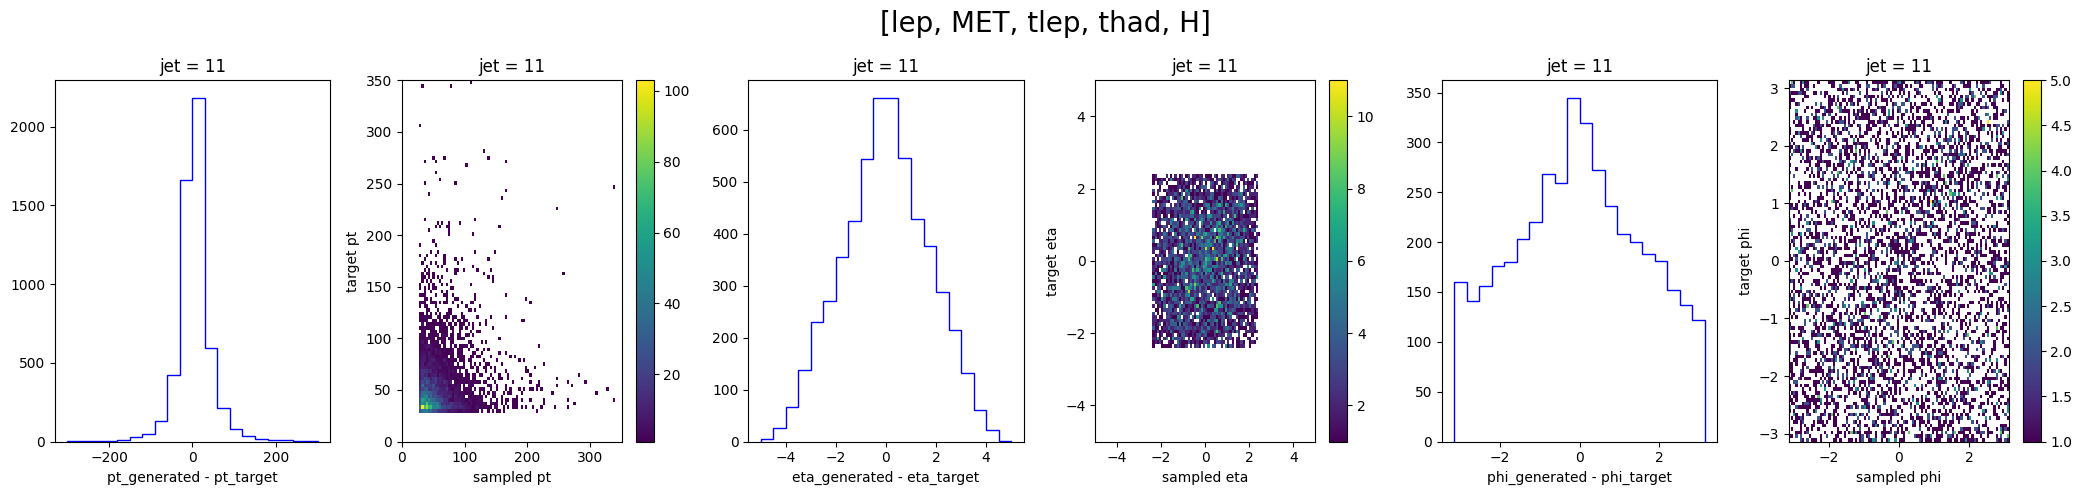

In [15]:
for i in range(12):
    sampling_print_unscaled(sampledAllEvent[:,1], sampledAllEvent[:,0], plotJets=i, onlyExistElem=True)

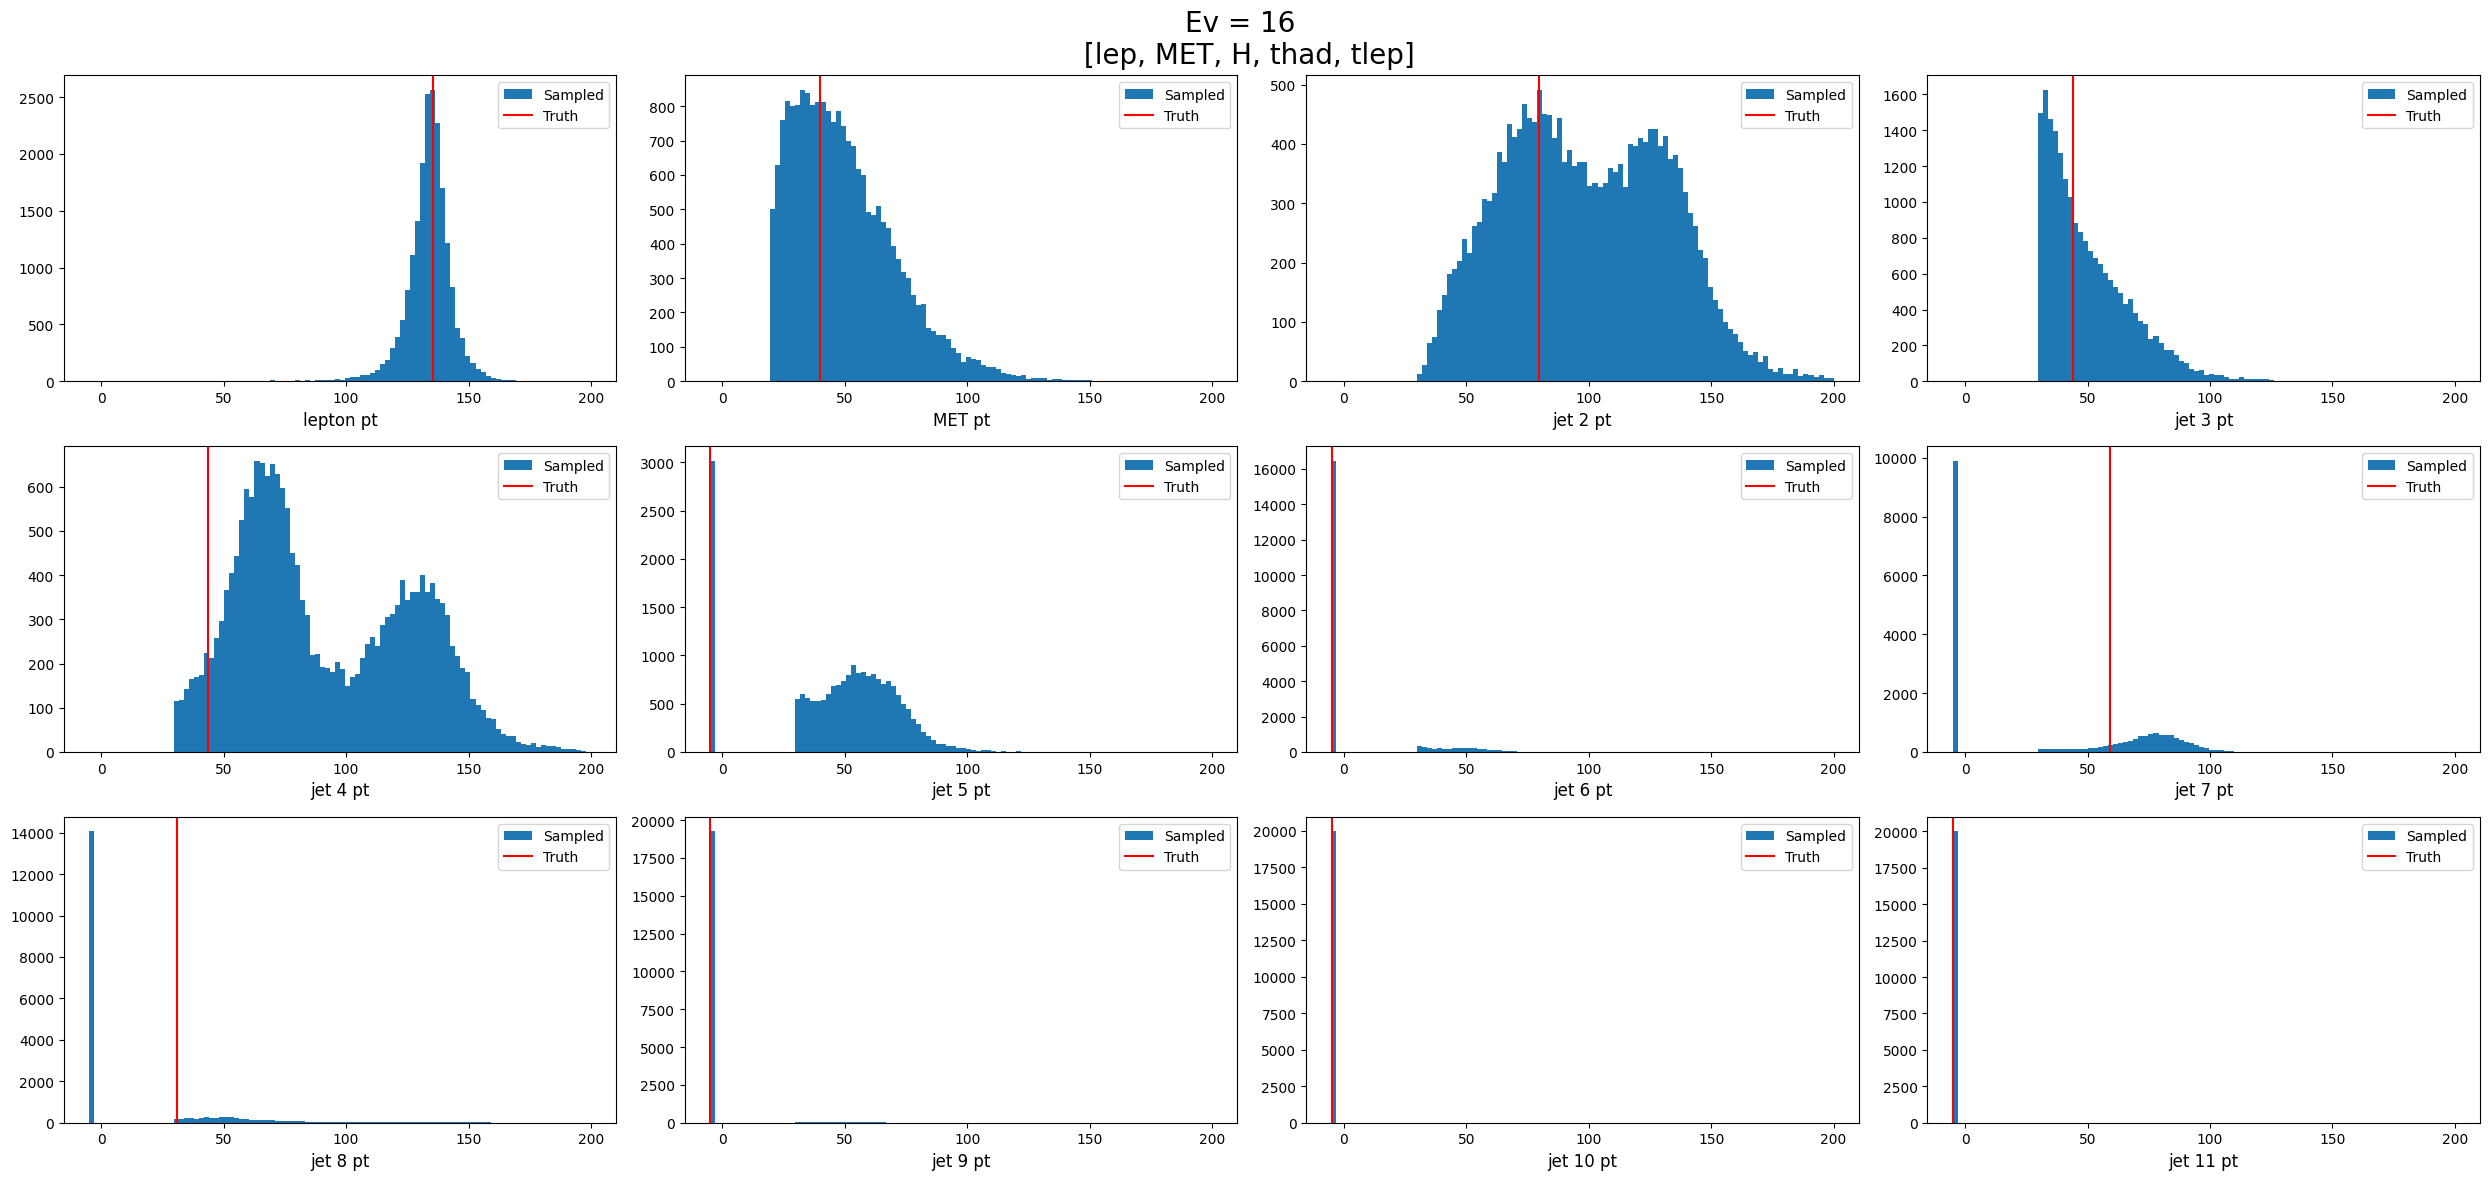

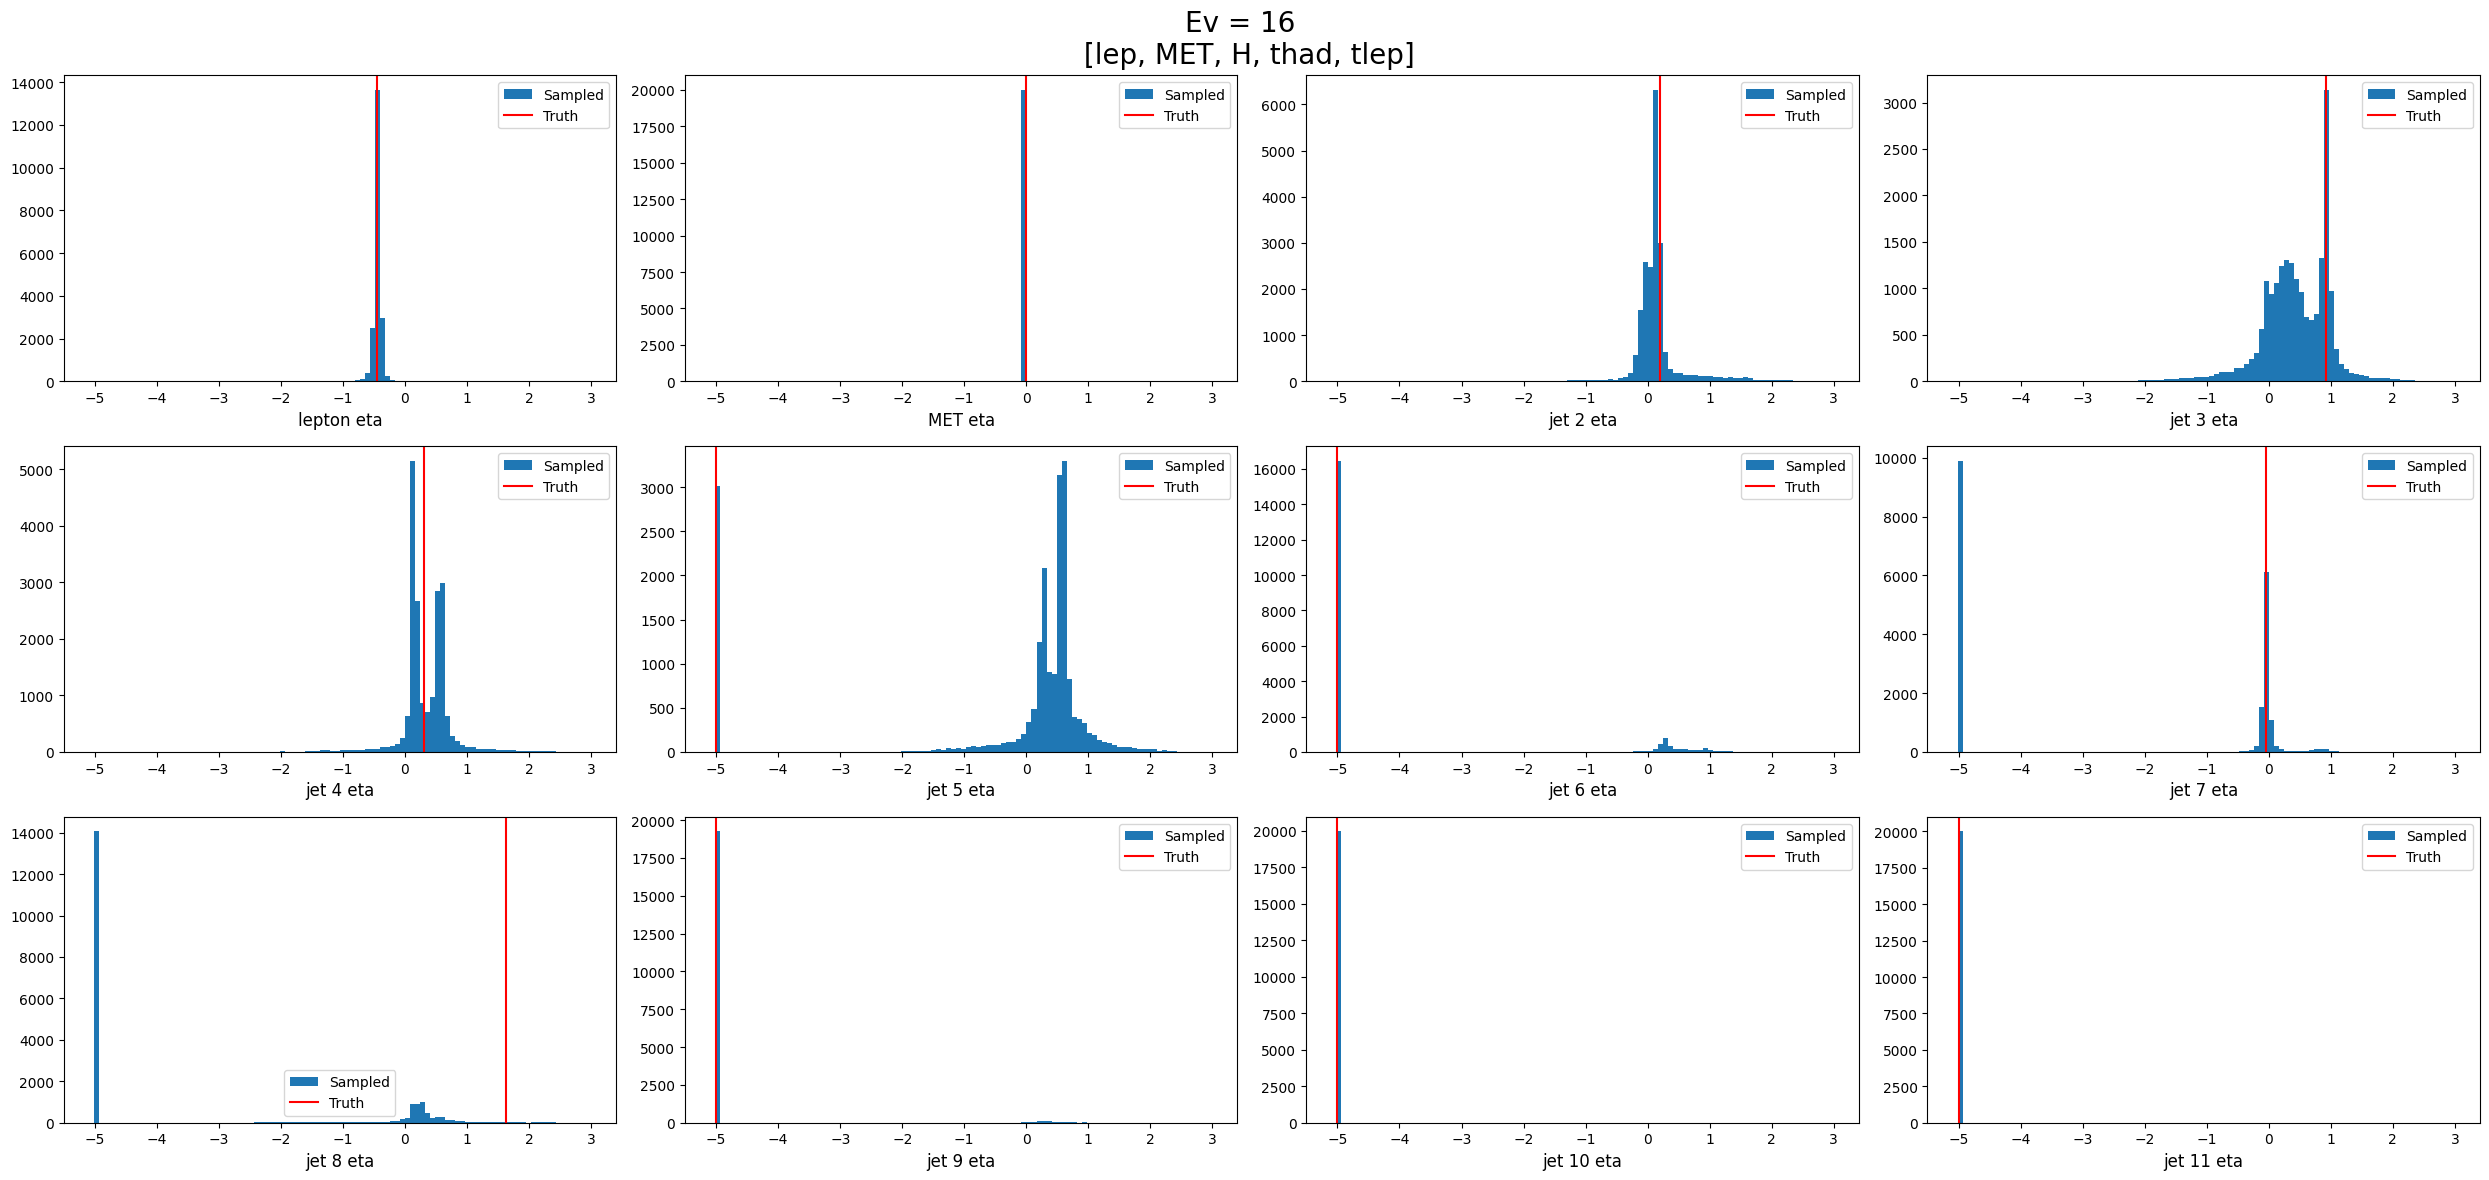

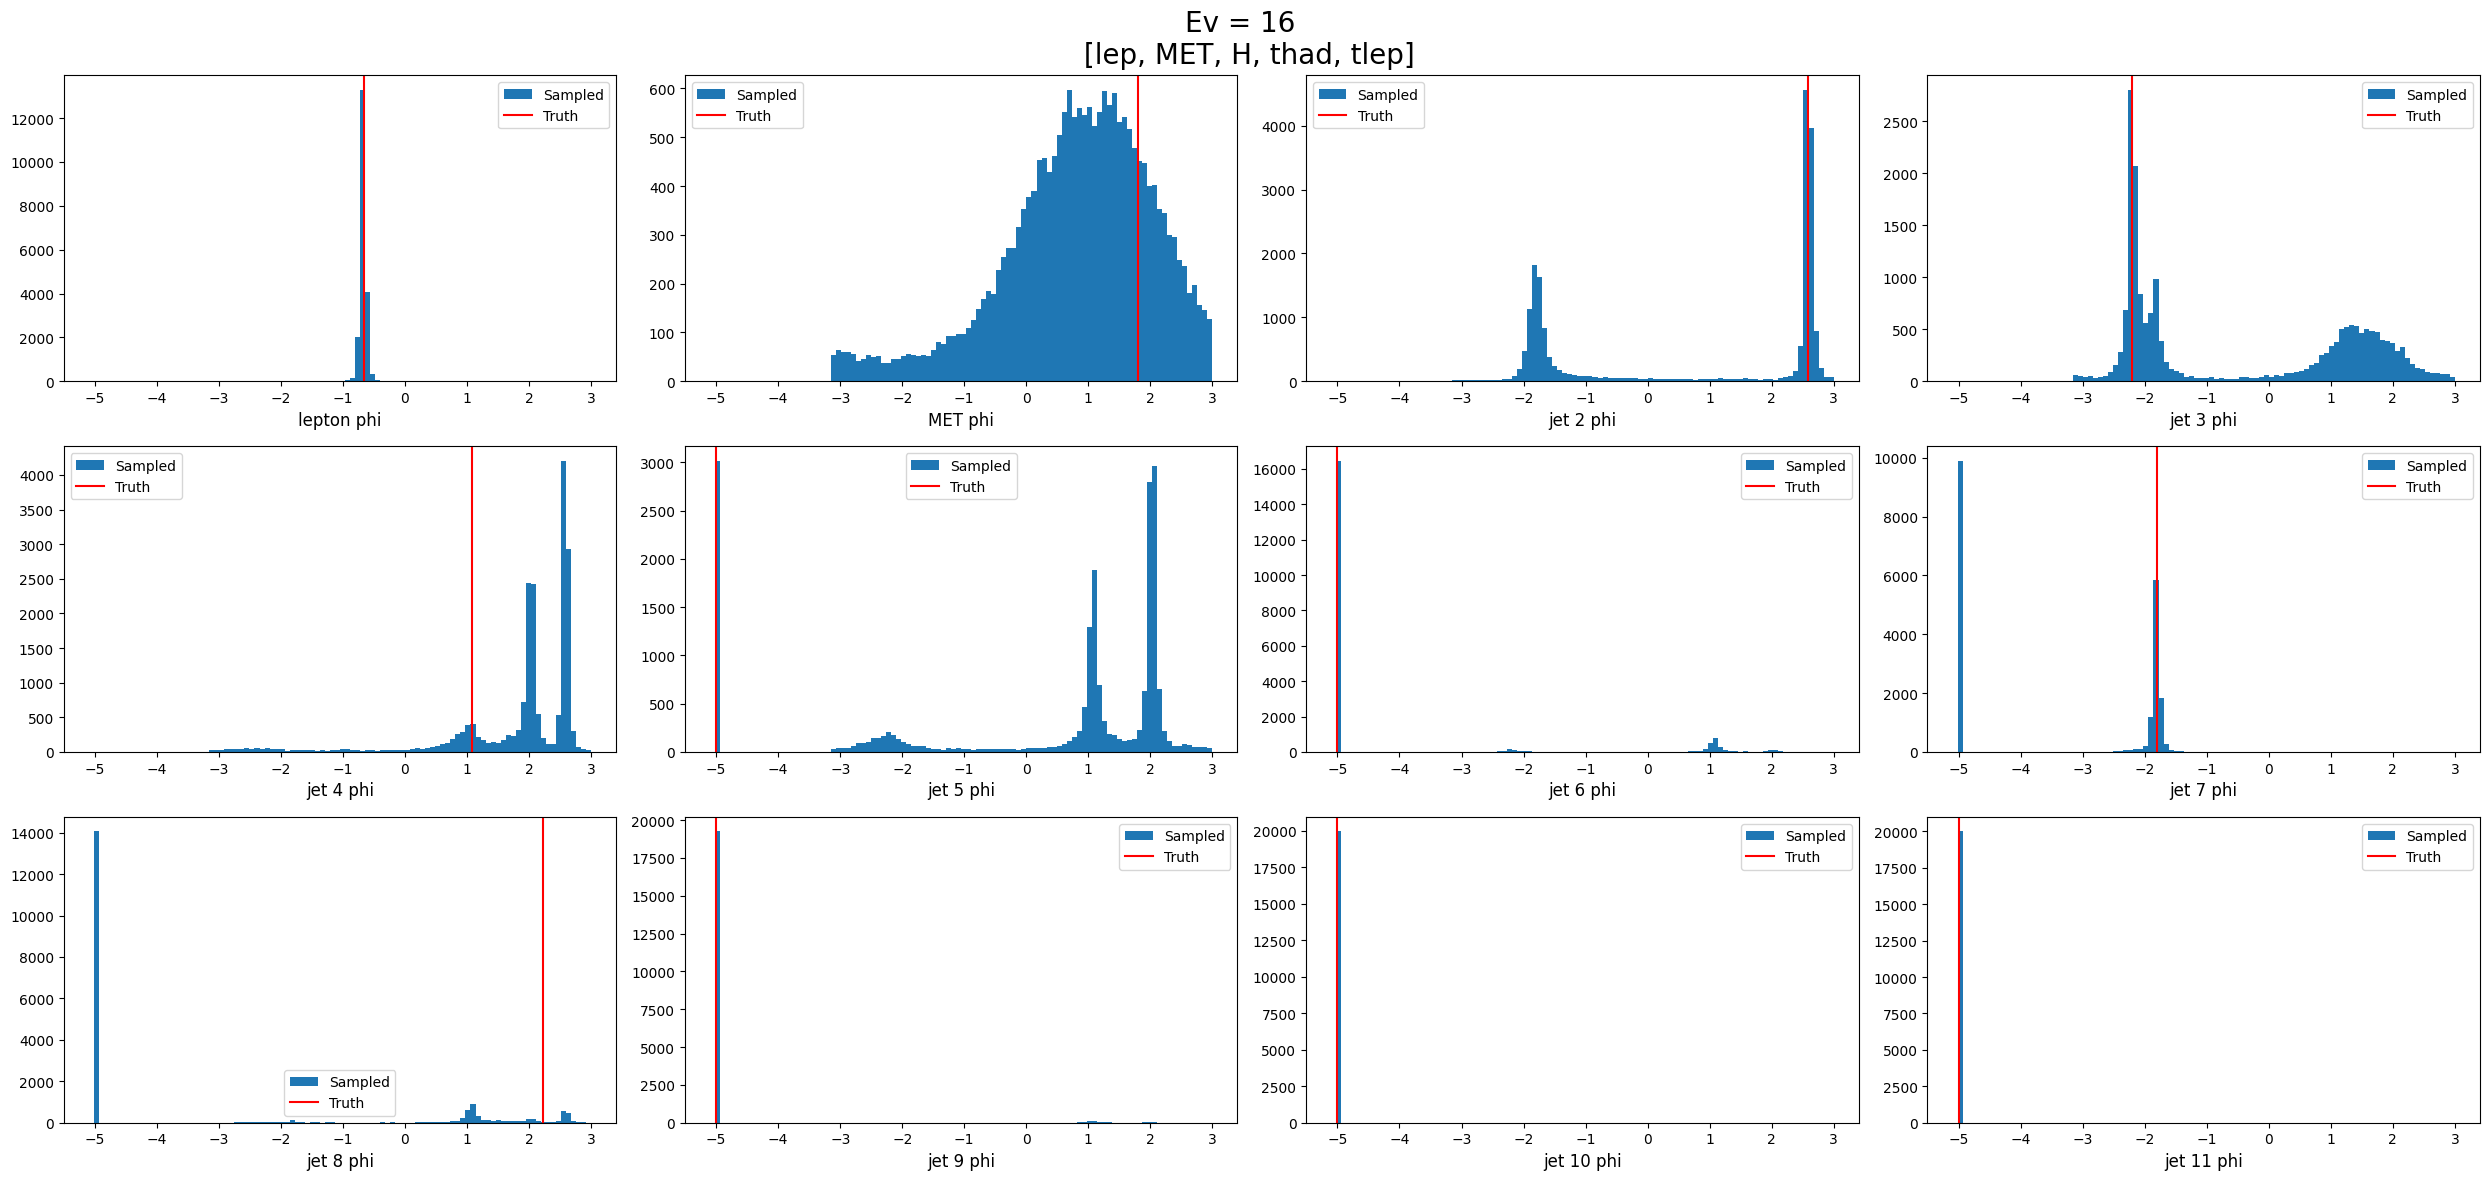

In [16]:
maxNoEv = sampledEvent.shape[0]
randomEv = random.randint(0, maxNoEv)
old_order = 2
sampling_print_oneEvent_oneVar(sampledEvent=sampledEvent[:,1:], targetEvent=sampledEvent[:,0], range_x=(-5.1,200),
                               evNo=randomEv, var='pt', noObjs=12, old_order=old_order)
sampling_print_oneEvent_oneVar(sampledEvent=sampledEvent[:,1:], targetEvent=sampledEvent[:,0], range_x=(-5.1,3),
                               evNo=randomEv, var='eta', noObjs=12, old_order=old_order)
sampling_print_oneEvent_oneVar(sampledEvent=sampledEvent[:,1:], targetEvent=sampledEvent[:,0], range_x=(-5.1,3),
                               evNo=randomEv, var='phi', noObjs=12, old_order=old_order)

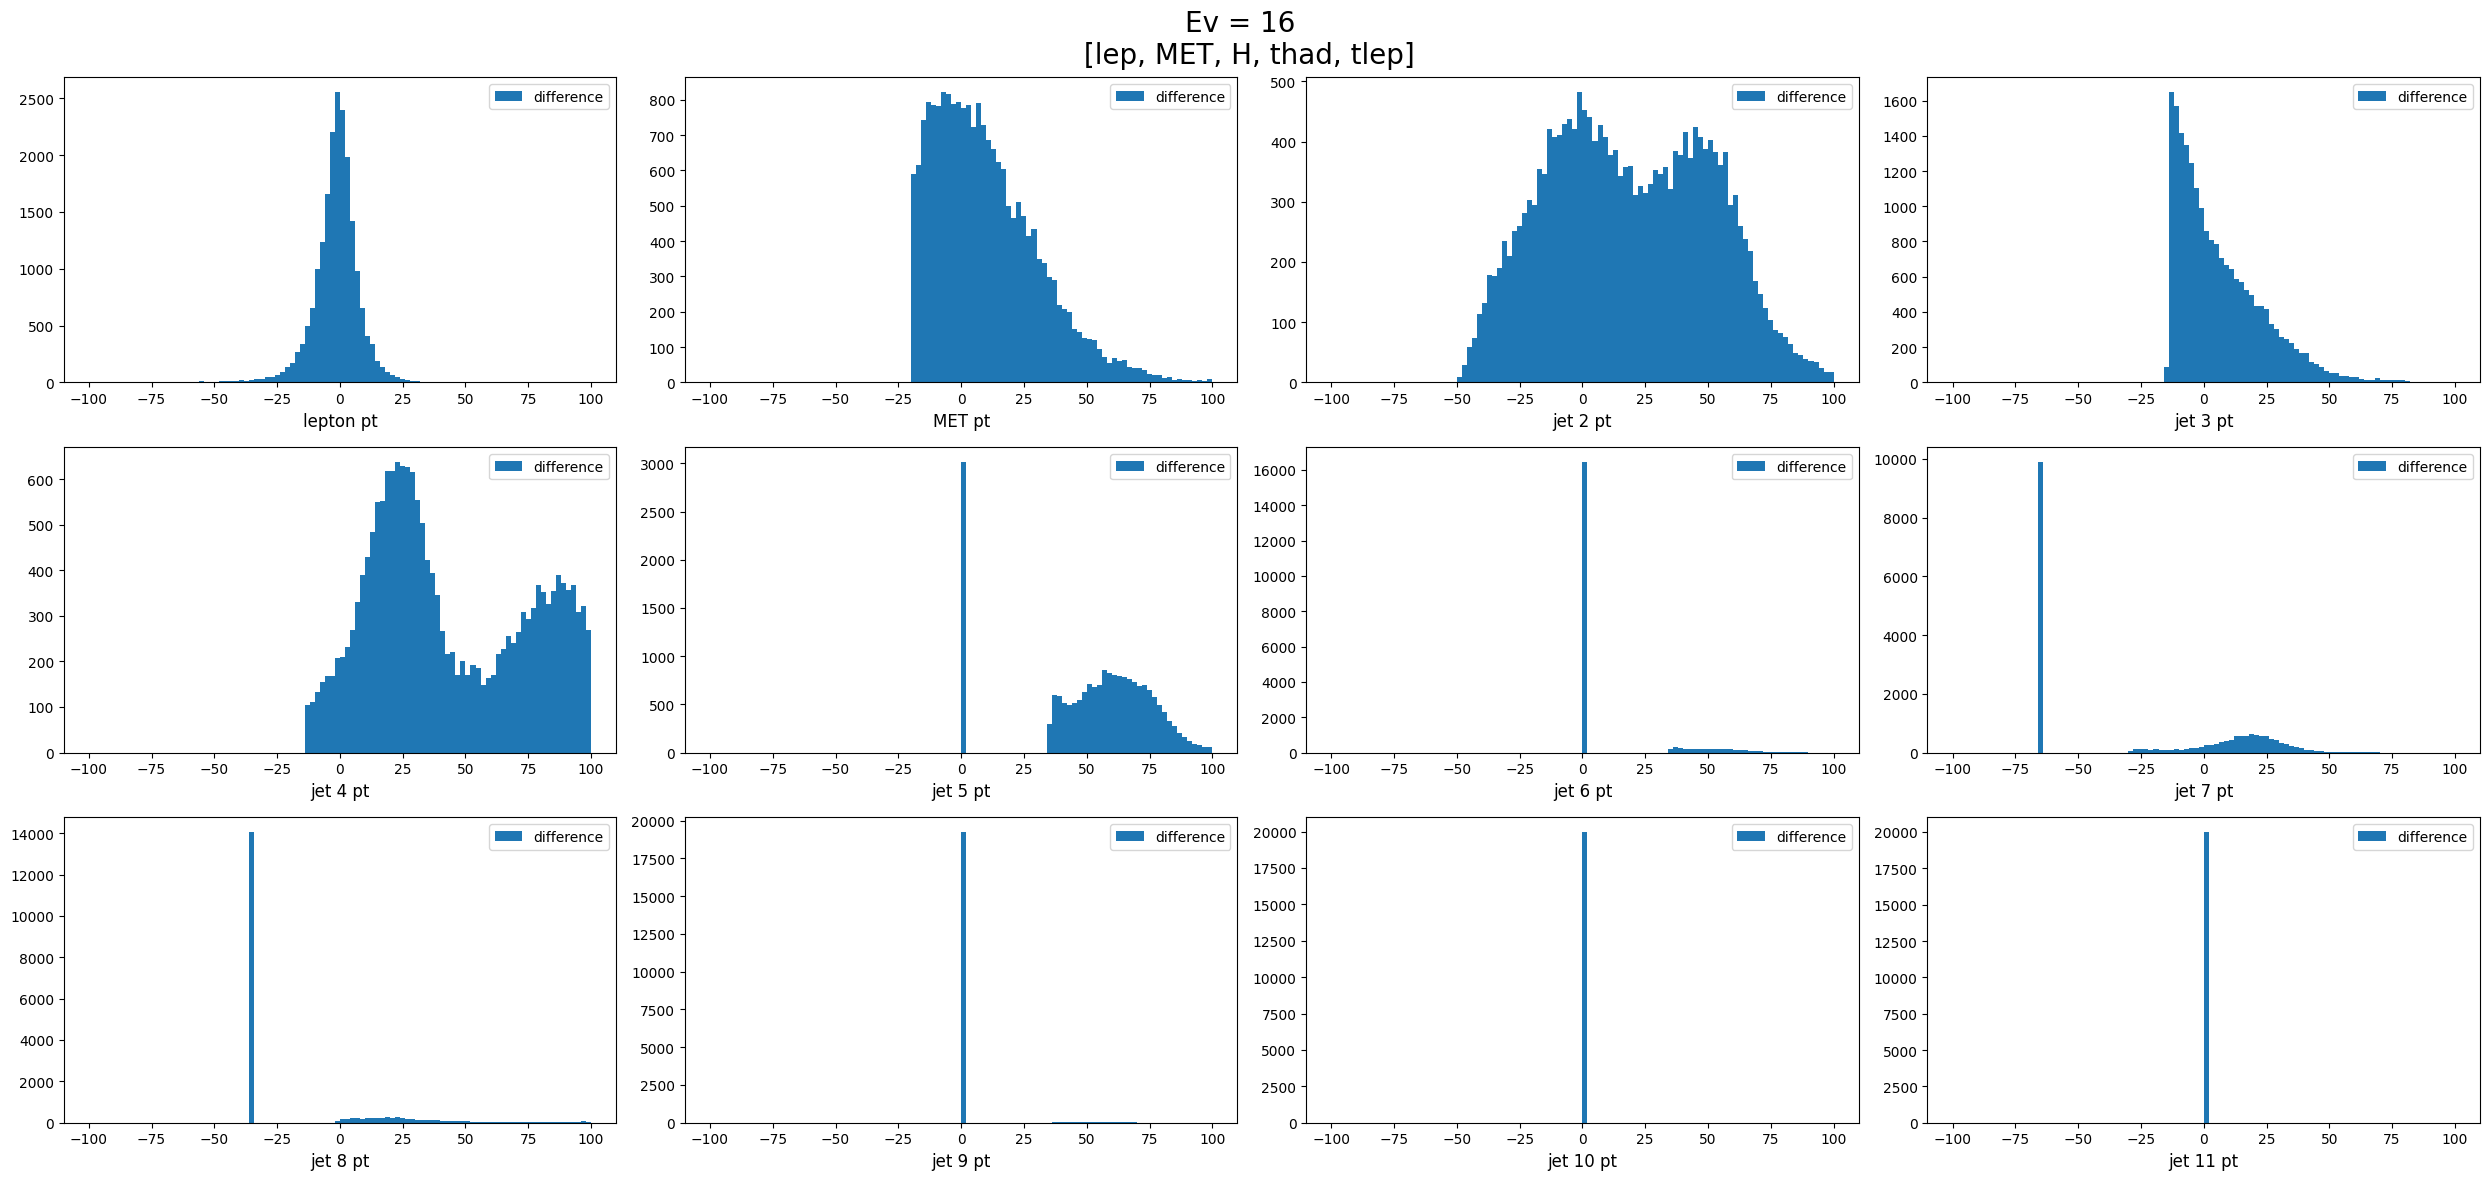

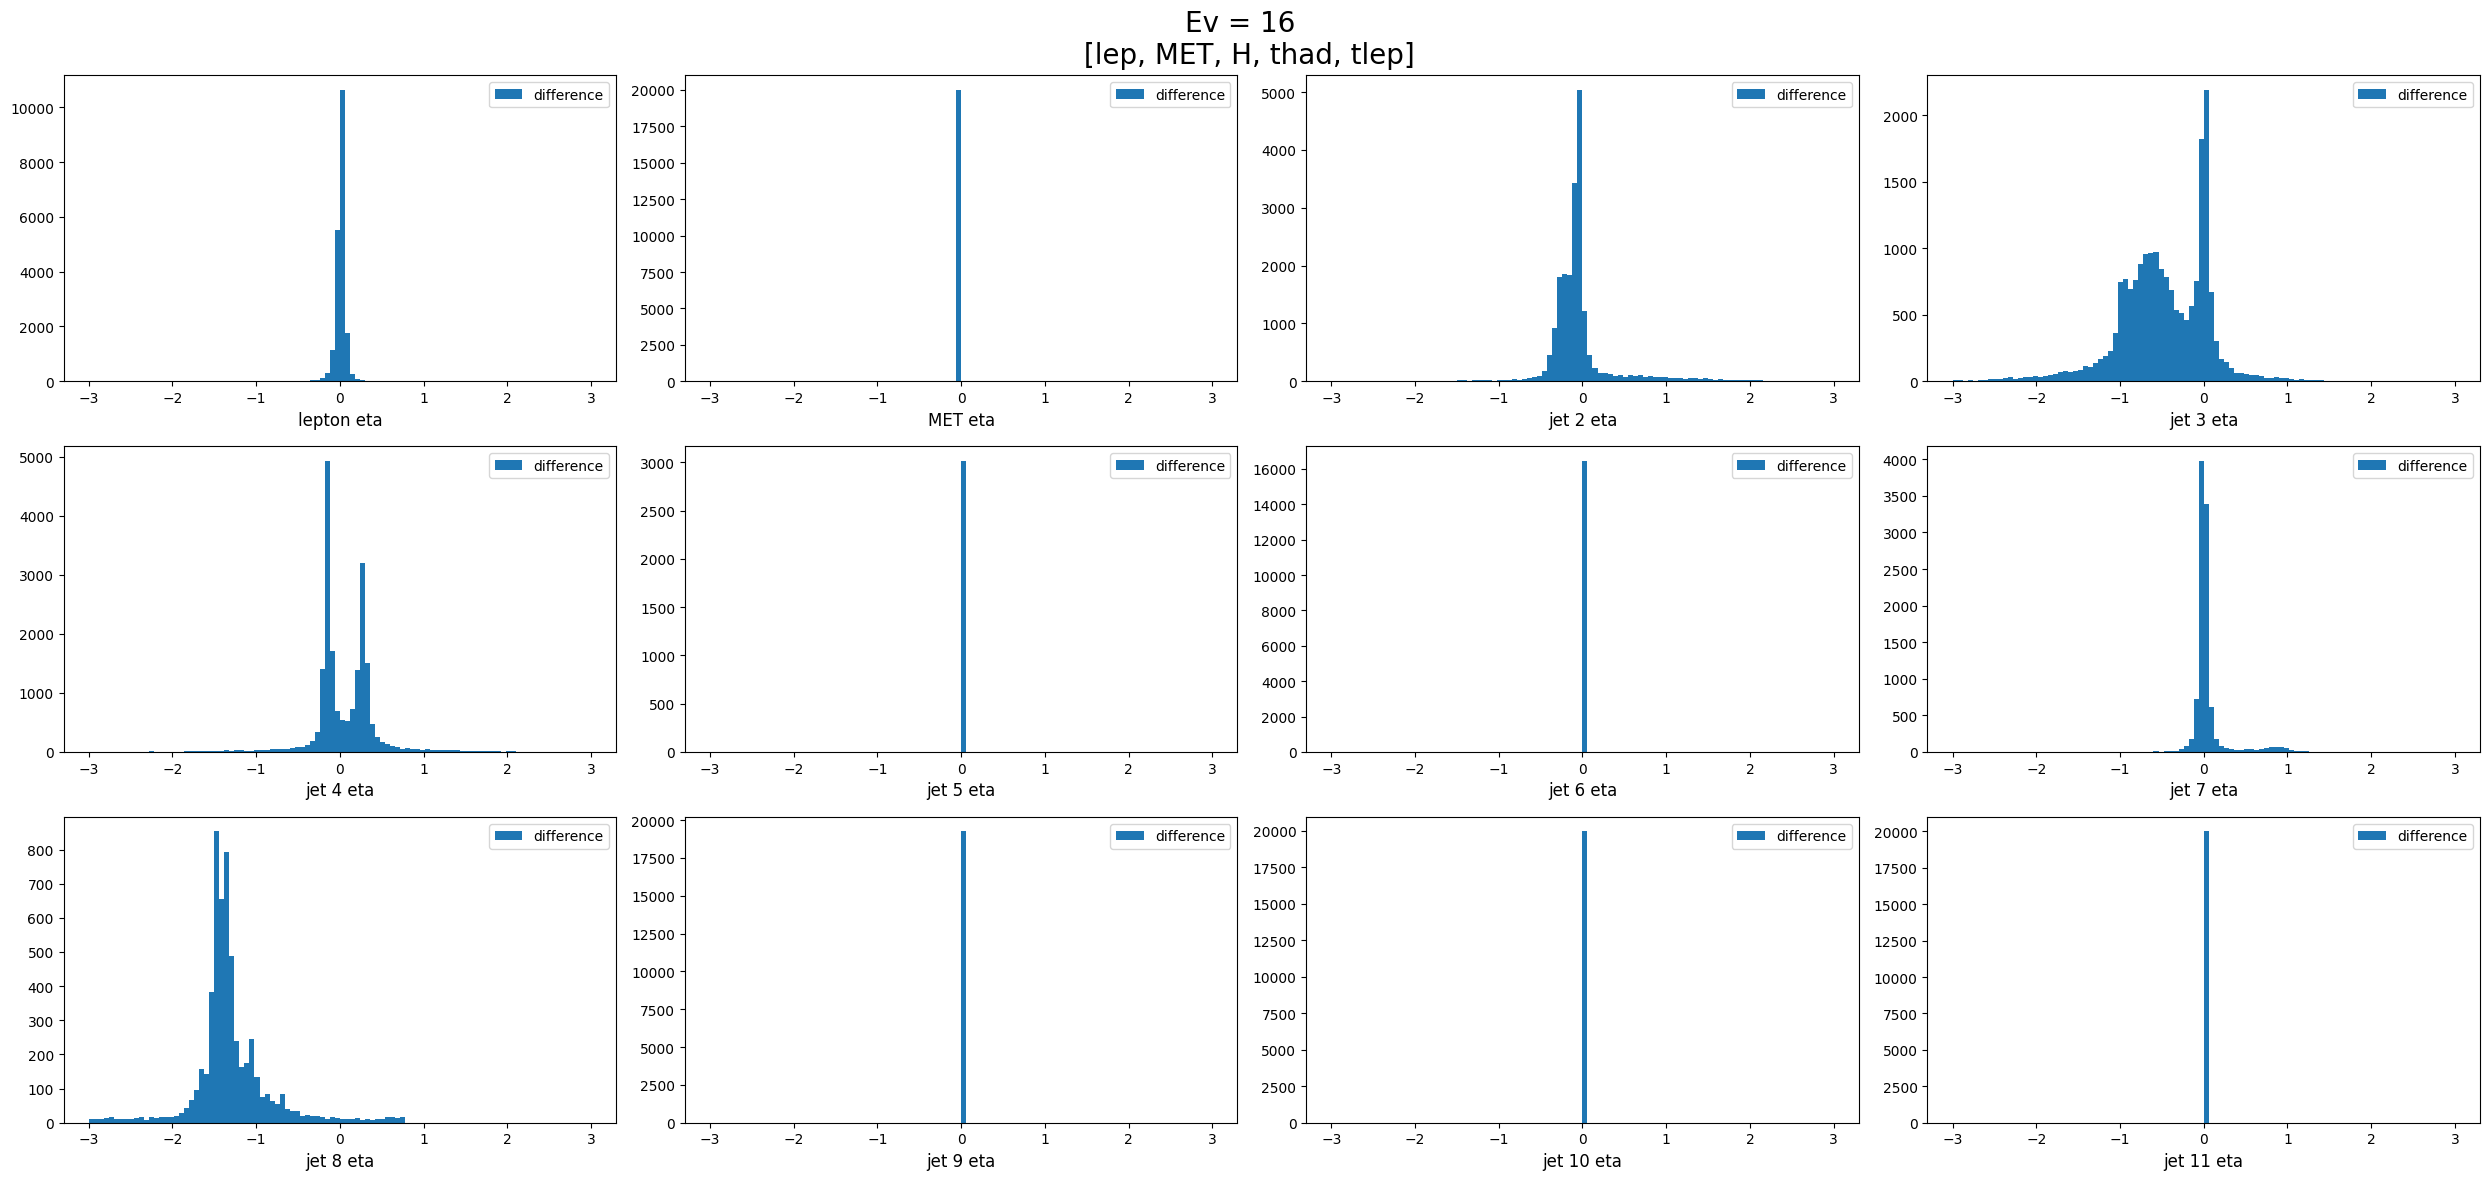

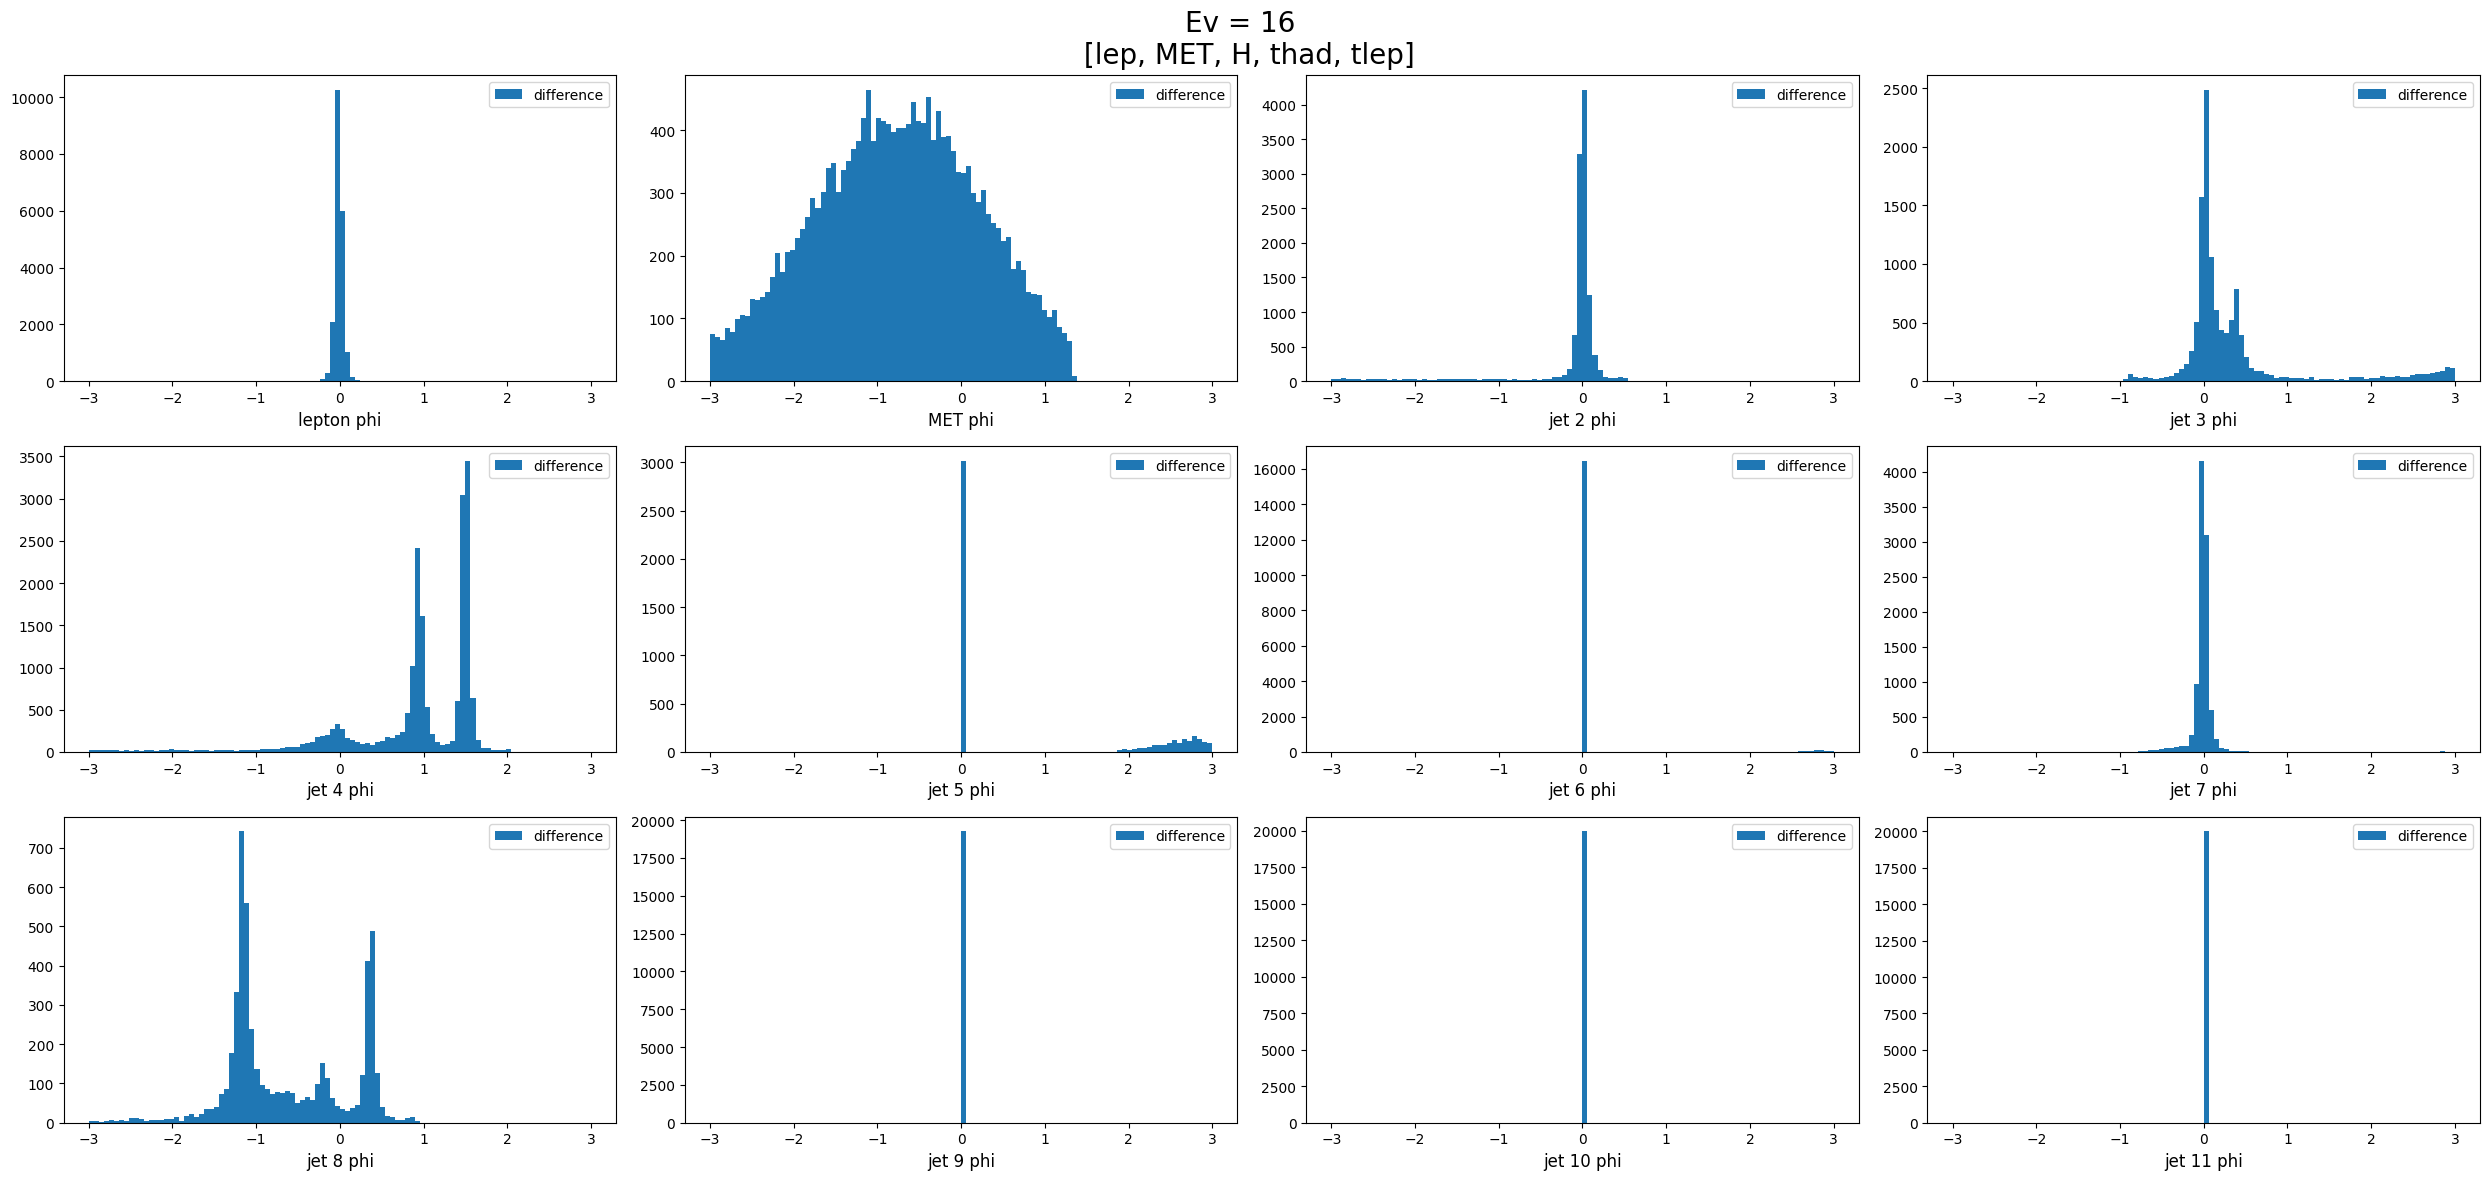

In [17]:
sampling_print_oneEvent_oneVar(sampledEvent=sampledEvent[:,1:], targetEvent=sampledEvent[:,0], range_x=(-100,100),
                               evNo=randomEv, var='pt', noObjs=12, old_order=old_order, difference=True)
sampling_print_oneEvent_oneVar(sampledEvent=sampledEvent[:,1:], targetEvent=sampledEvent[:,0], range_x=(-3,3),
                               evNo=randomEv, var='eta', noObjs=12, old_order=old_order, difference=True)
sampling_print_oneEvent_oneVar(sampledEvent=sampledEvent[:,1:], targetEvent=sampledEvent[:,0], range_x=(-3,3),
                               evNo=randomEv, var='phi', noObjs=12, old_order=old_order, difference=True)

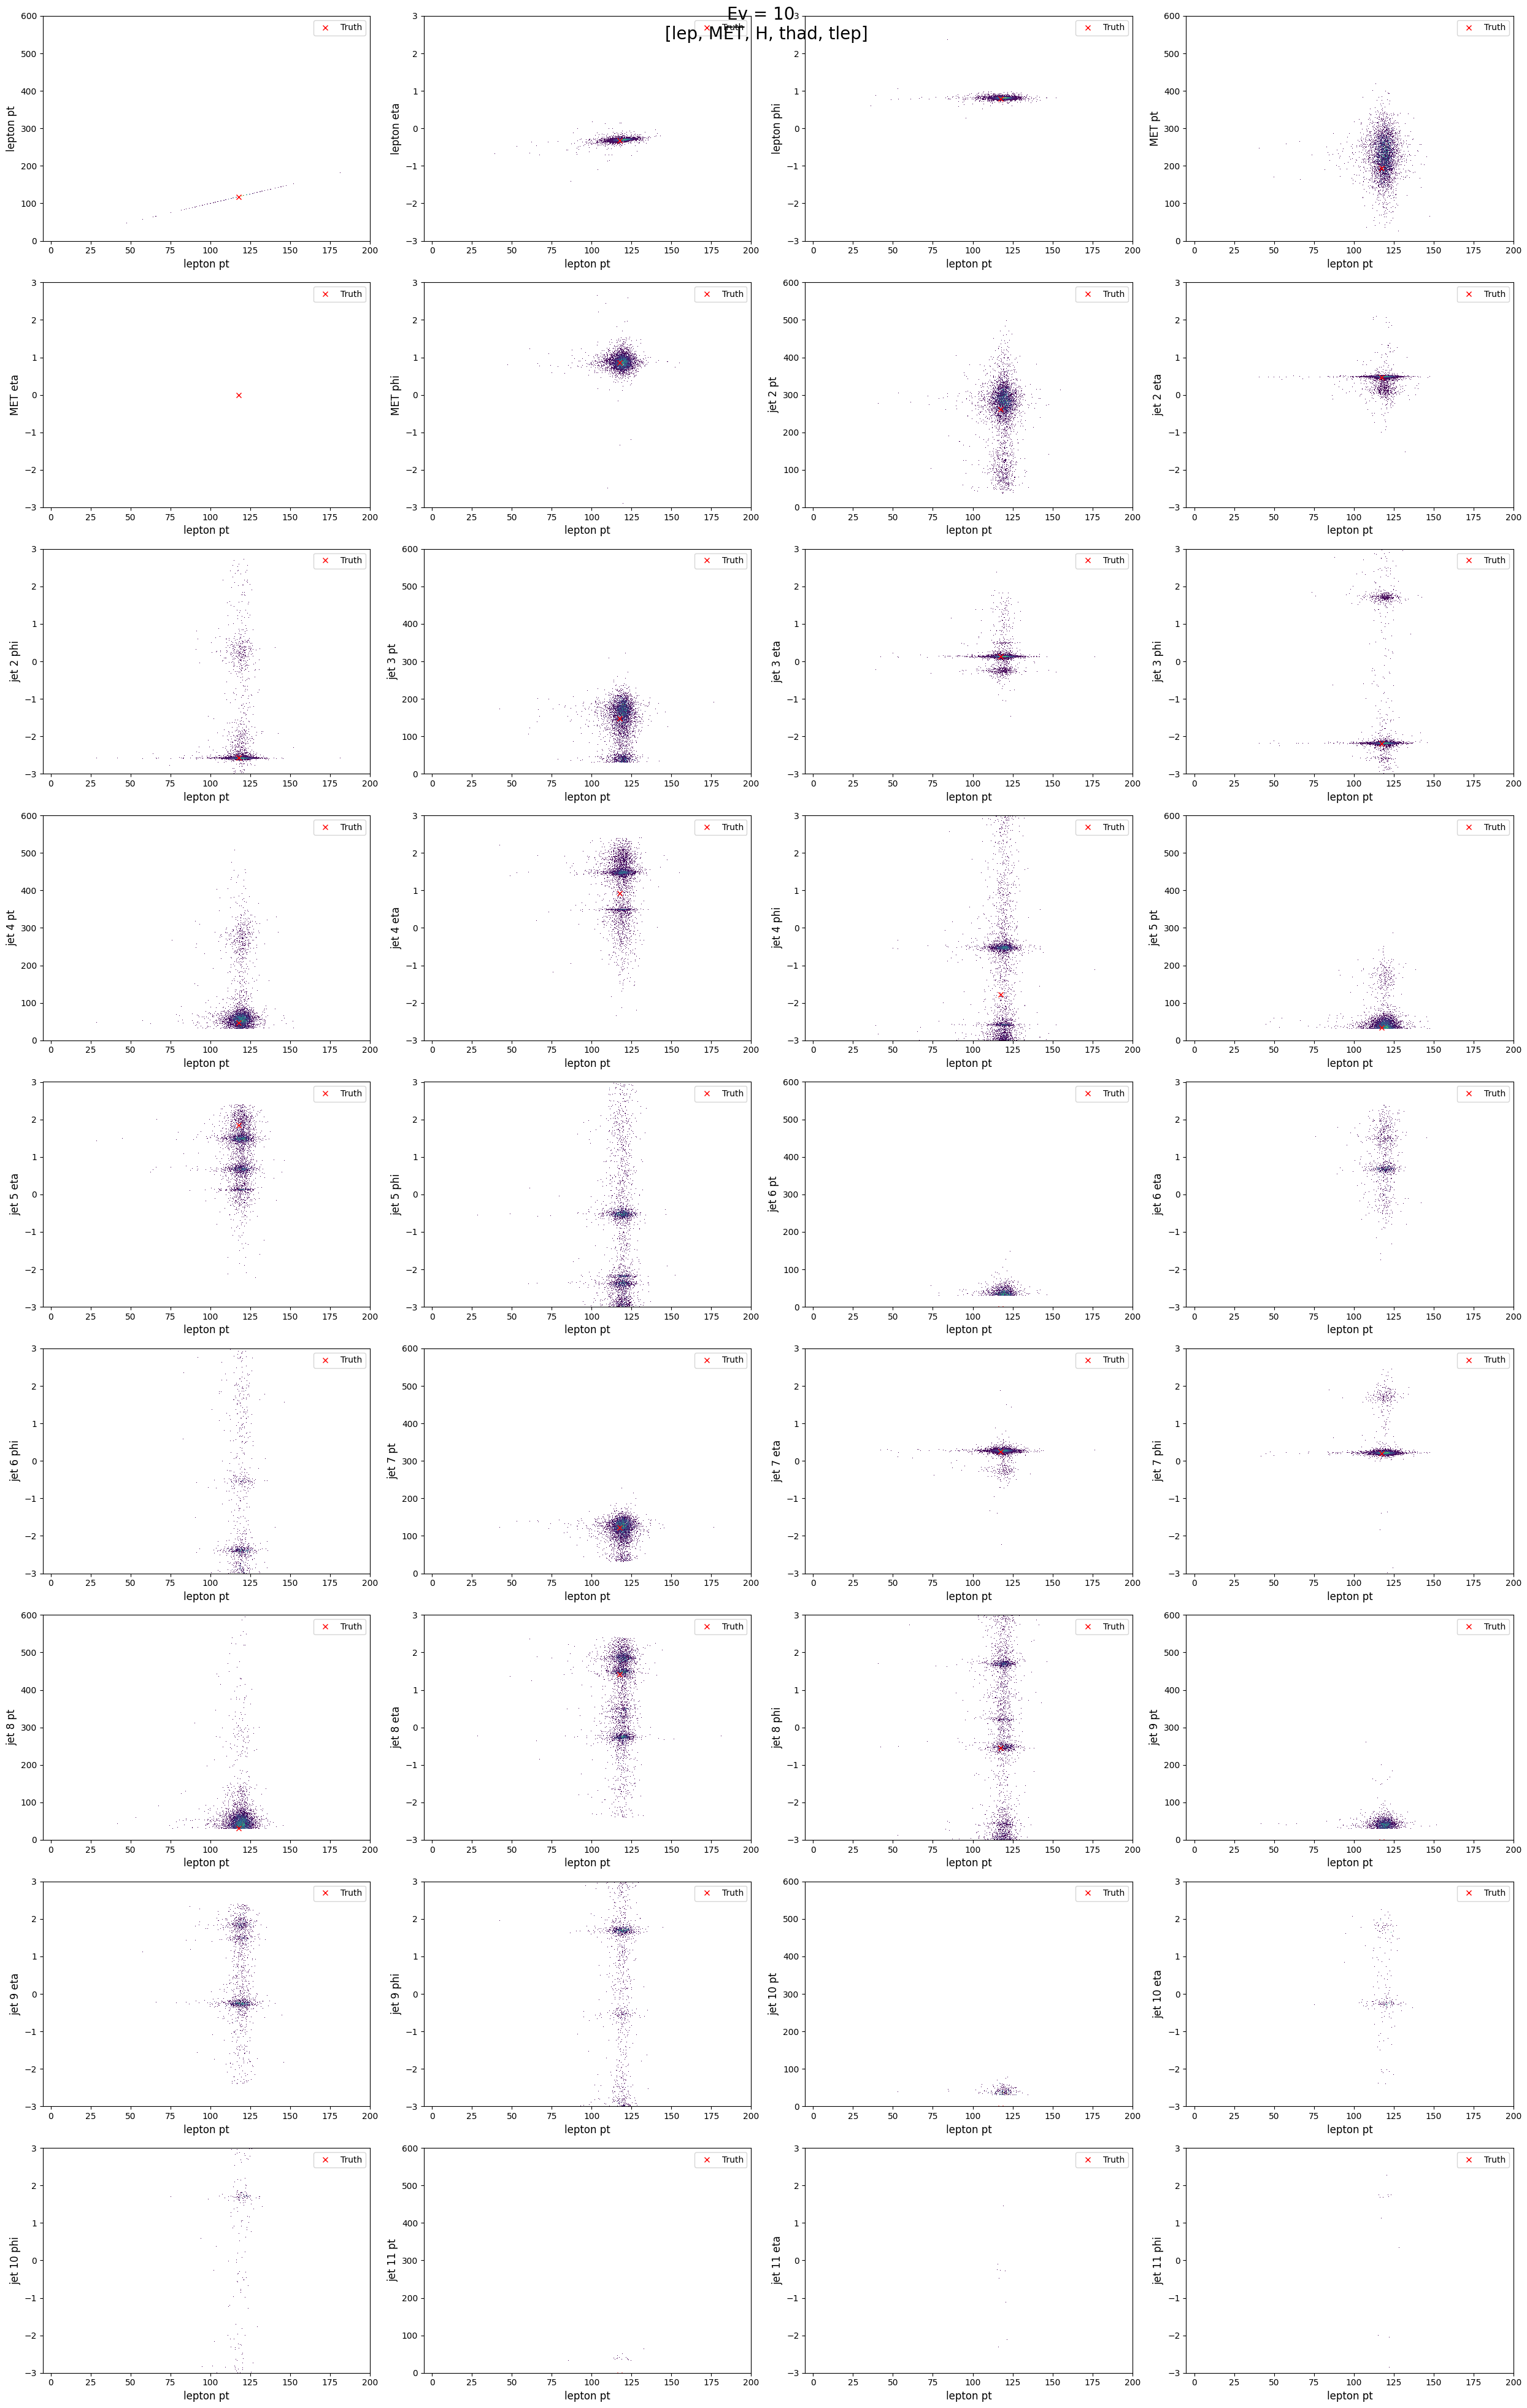

In [18]:
sampling_print_oneEvent_2Dcorr(sampledEvent[:,1:], targetEvent=sampledEvent[:,0], evNo=10, jetNo=0, var='pt',
                                   noObjs=12, range_x=(-5.1,200), xlabel='x', ylabel='y', old_order=old_order)

# Bias + Uncertainty

In [17]:
print(sampledAllEvent[:,1:,0,1].shape)
print(sampledAllEvent[:,0,0,1].shape)

torch.Size([1792000, 30])
torch.Size([1792000])


In [18]:
from numba import jit
@jit(nopython=True)
def get_central_smallest_interval(array, xrange, nbins, Ntrial=10000, perc=0.68):
    H = np.histogram(array, bins=nbins, range=xrange)
        # trying to smooth out noisy histo

    xmax_l = H[1][np.argmax(H[0])-5]
    xmax_h = H[1][np.argmax(H[0])+5]
    xmax = np.mean(array[(array>xmax_l)&(array<xmax_h)])
    
    deltax = (xrange[1]-xrange[0])/(2*Ntrial)

    absmax = np.quantile(array, 0.995)
    absmin = np.quantile(array, 0.005)
    
    N = array.shape[0]
    xd = xmax-deltax
    xu = xmax+deltax
    for i in range(Ntrial):
        q = np.sum((array>xd) &(array<xu))/ N
        if q>=perc: 
            break
        if xd > absmin:
            xd = xd-deltax
        if xu < absmax:
            xu = xu+deltax
    return xmax, xd, xu

import mplhep as hep
plt.style.use(hep.style.CMS)

def plot_diff_mode_quantile(Y, X, cat_var, bins,
                      xlabel='', ylabel='', title='', title_pos=(0.2,0.9),
                    debug=False,
                    xlim=None, ylim=None, nbins_mode=100, output_file=None):
    
    Y_mode  = []
    X_avg = []
    quantile_right_list = []
    quantile_left_list = []
    quantile_right_list_95 = []
    quantile_left_list_95 = []

    for i in range(len(bins)-1):
        mask = ((cat_var >= bins[i])&(cat_var< bins[i+1]))
        Ymask = Y[mask]
        X_avg.append(np.mean(X[mask]))

        #print((np.min(Ymask), np.max(Ymask)))
        mode, left, right = get_central_smallest_interval(Ymask, xrange=(np.quantile(Ymask, 0.03), np.quantile(Ymask, 0.97)),
                                      nbins=Ymask.size//nbins_mode, Ntrial=2000, perc=0.68)

        _, left95, right95 = get_central_smallest_interval(Ymask, xrange=(np.quantile(Ymask, 0.03), np.quantile(Ymask, 0.97)),
                                      nbins=Ymask.size//nbins_mode, Ntrial=2000, perc=0.95)

        if debug:
            f = plt.figure()
            plt.hist(Ymask, range=(np.quantile(Ymask, 0.03), np.quantile(Ymask, 0.97)),   bins=Ymask.size//100, histtype="step")
            plt.axvline(left, c='r', label="0.68")
            plt.axvline(right, c='r')
            plt.axvline(left95, c='orange', label="0.95")
            plt.axvline(right95, c='orange')
            plt.axvline(mode, label="mode", c="green")
            plt.title(f"Bins {bins[i]:.2f}-{bins[i+1]:.2}")
            plt.legend()
            plt.show()

        
        Y_mode.append(mode)
        quantile_left_list.append(left)
        quantile_right_list.append(right)
        quantile_left_list_95.append(left95)
        quantile_right_list_95.append(right95)
        #print(Y_mode, left, right)

    offset_left = np.array(Y_mode) - np.array(quantile_left_list) # need offset
    offset_right = np.array(quantile_right_list) - np.array(Y_mode)
    
    offset_left_95 = np.array(Y_mode) - np.array(np.array(quantile_left_list_95)) # need offset
    offset_right_95 = np.array(quantile_right_list_95) - np.array(Y_mode)

    f  = plt.figure(figsize=(7,6), dpi=150)
    ax = plt.gca()
    
    ax.plot(X_avg, Y_mode, linestyle='-', marker='o', color='k', label="mode")
    ax.grid(axis="y")
        
    ax.fill_between(X_avg, Y_mode - offset_left, Y_mode + offset_right,
                     color='r', alpha=0.2, label='68% CL')
    ax.fill_between(X_avg, Y_mode - offset_left_95, Y_mode + offset_right_95,
                     color='b', alpha=0.15, label='95% CL')
    ax.legend(facecolor='white',framealpha=1, fontsize=16 )
    ax.set_xlabel(xlabel, fontsize=17)
    ax.set_ylabel(ylabel, fontsize=17)
    ax.tick_params(axis='both', which='major', labelsize=15)
    if xlim:
        ax.set_xlim(*xlim)
    if ylim:
        ax.set_ylim(*ylim)
    ax.text(title_pos[0], title_pos[1], title, fontsize=20, transform=ax.transAxes)
    hep.cms.label(rlabel="13 TeV",  llabel="Simulation Preliminary", loc=0, ax=ax,fontsize=20)
    #if output_file:
        #plt.tight_layout()
        #plt.subplots_adjust(left=0.2, right=0.8)
        #plt.savefig(output_file +".png")
        #plt.savefig(output_file +".pdf")

In [22]:
diff_eta = sampledAllEvent[:,1:,0,1] - sampledAllEvent[:,0,0,1].unsqueeze(dim=1)
diff_eta_avgEachEvent = torch.mean(diff_eta, dim=1)
print(diff_eta.shape)
print(diff_eta_avgEachEvent.shape)

torch.Size([1792000, 30])
torch.Size([1792000])


1792000


ZeroDivisionError: division by zero

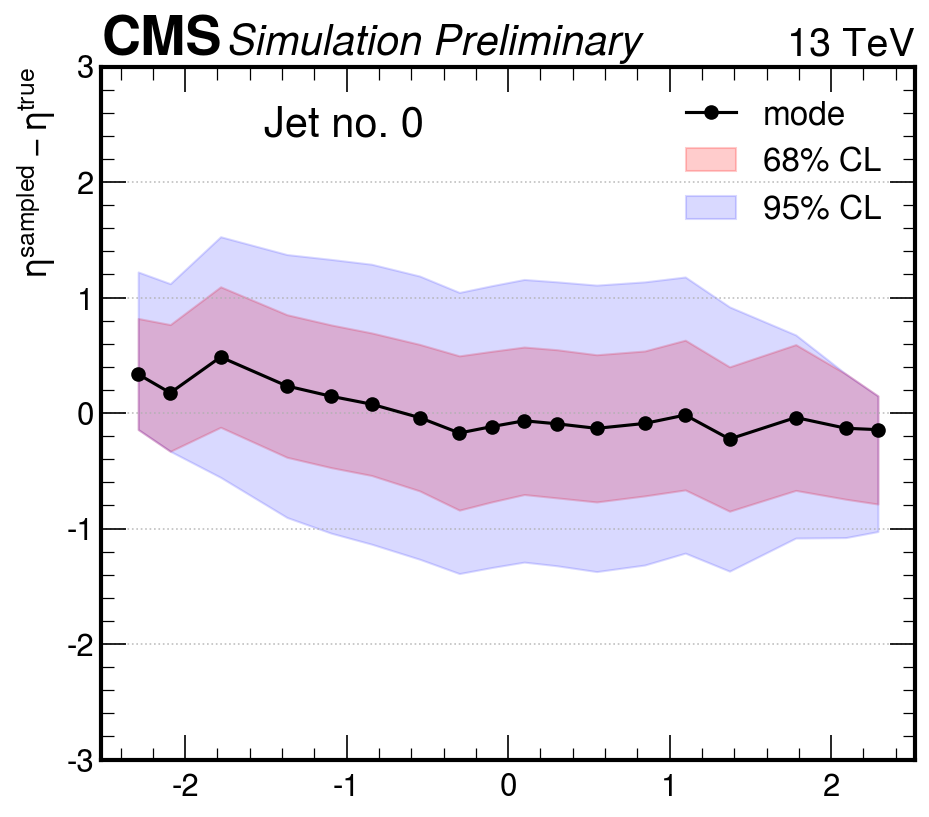

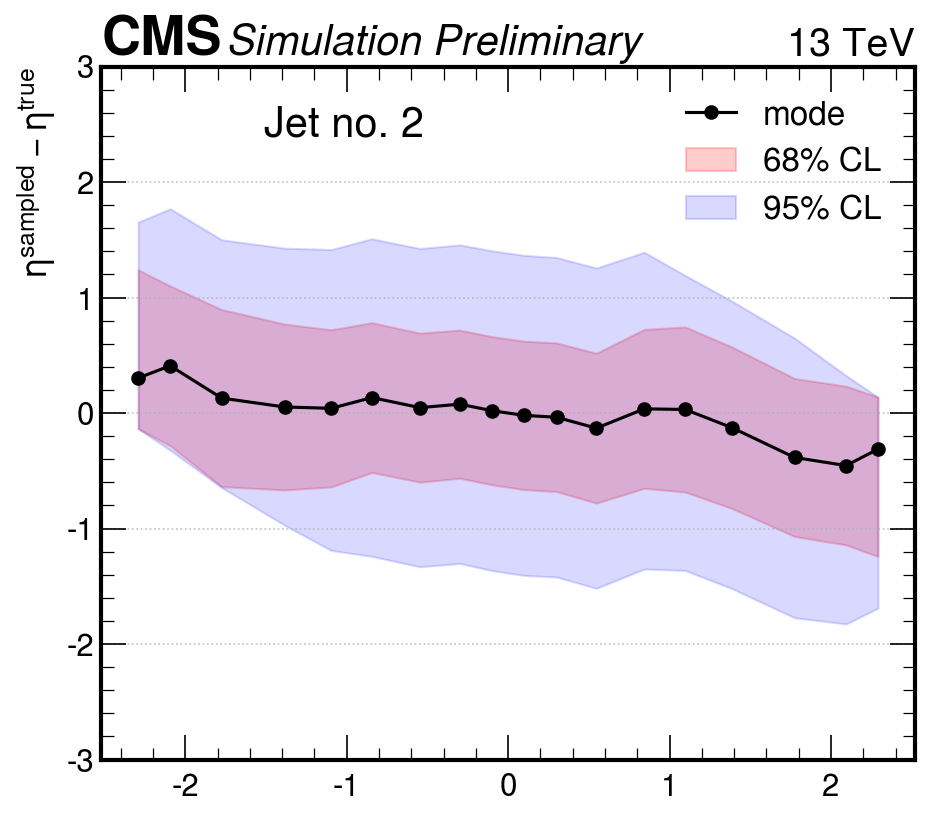

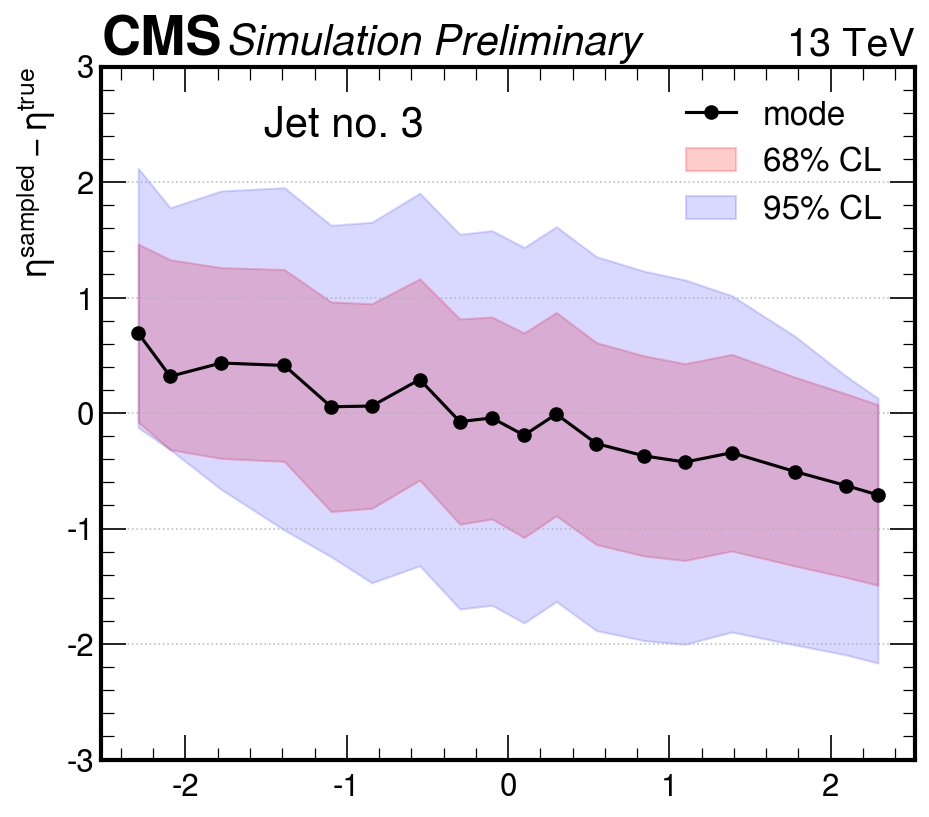

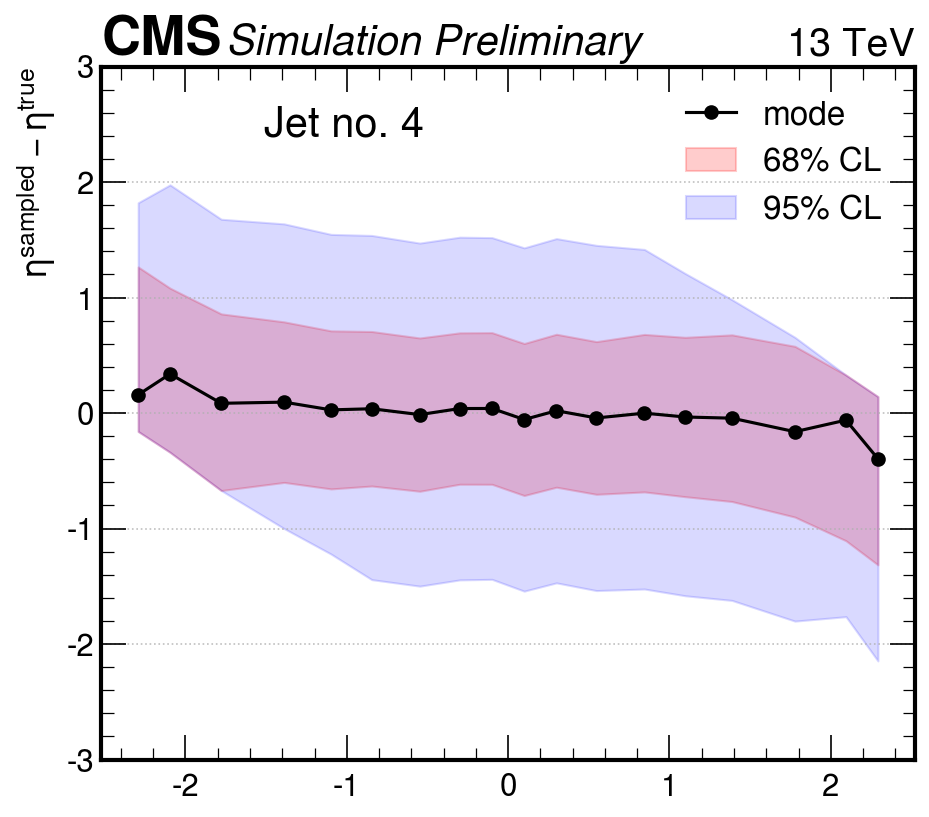

In [39]:
No_samples = 30
print(sampledAllEvent.size(0))

for jet in range(12):

    if jet == 1:
        continue

    diff_eta = sampledAllEvent[:,1:,jet,1] - sampledAllEvent[:,0,jet,1].unsqueeze(dim=1) # sampled - target
    diff_eta_flat = torch.flatten(diff_eta)
    #print(diff_eta[1,0])
    #print(diff_eta[1,1])
    #print(sampledAllEvent[1,0,jet,1])

    targetEtaRepeated = sampledAllEvent[:,0,jet,1].repeat_interleave(No_samples)

    #print()
    #print(diff_eta_flat[30])
    #print(diff_eta_flat[31])
    #print(targetRepeated[30])
    #print(targetRepeated[31])
    
    plot_diff_mode_quantile(diff_eta_flat.numpy(), 
                            X=targetEtaRepeated.numpy(),  
                            cat_var=targetEtaRepeated.numpy(), 
                            bins=[-4,-2.2,-2.,-1.6, -1.2, -1.0, 
                                   -0.7, -0.4, -0.2, -0., 0.2,0.4, 0.7,
                                   1., 1.2, 1.6, 2., 2.2,4],
                            xlabel='', ylim=(-3,3),
                            ylabel='$\eta^{sampled} - \eta^{true}$', title=f'Jet no. {jet}',nbins_mode=50)


1792000


ZeroDivisionError: division by zero

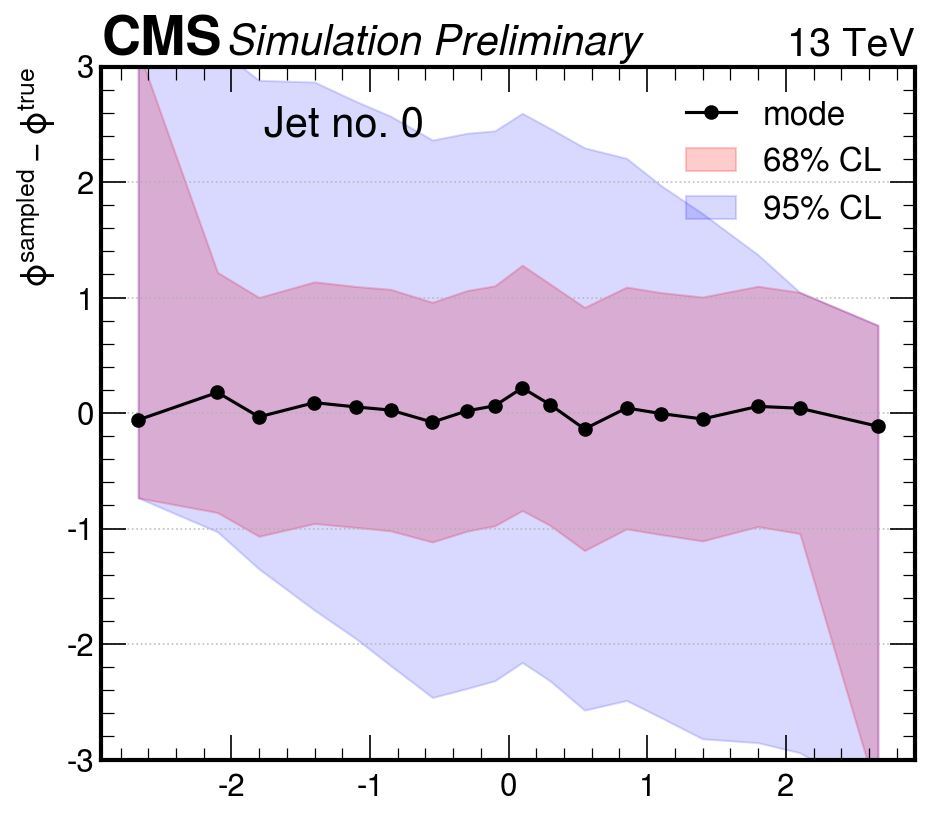

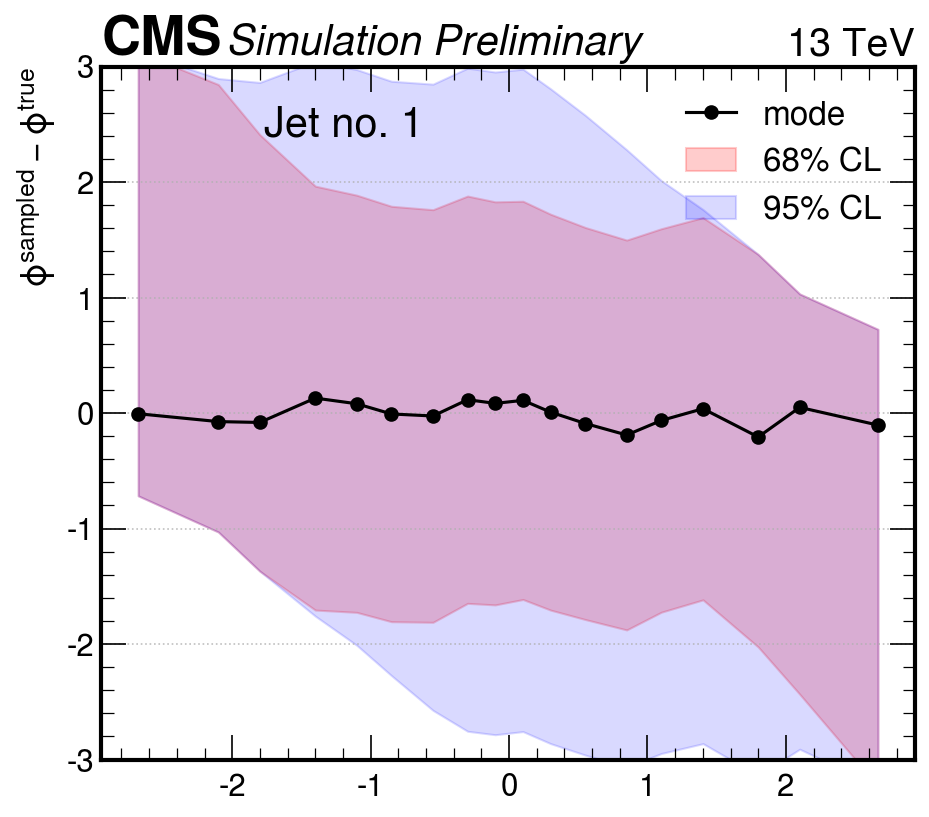

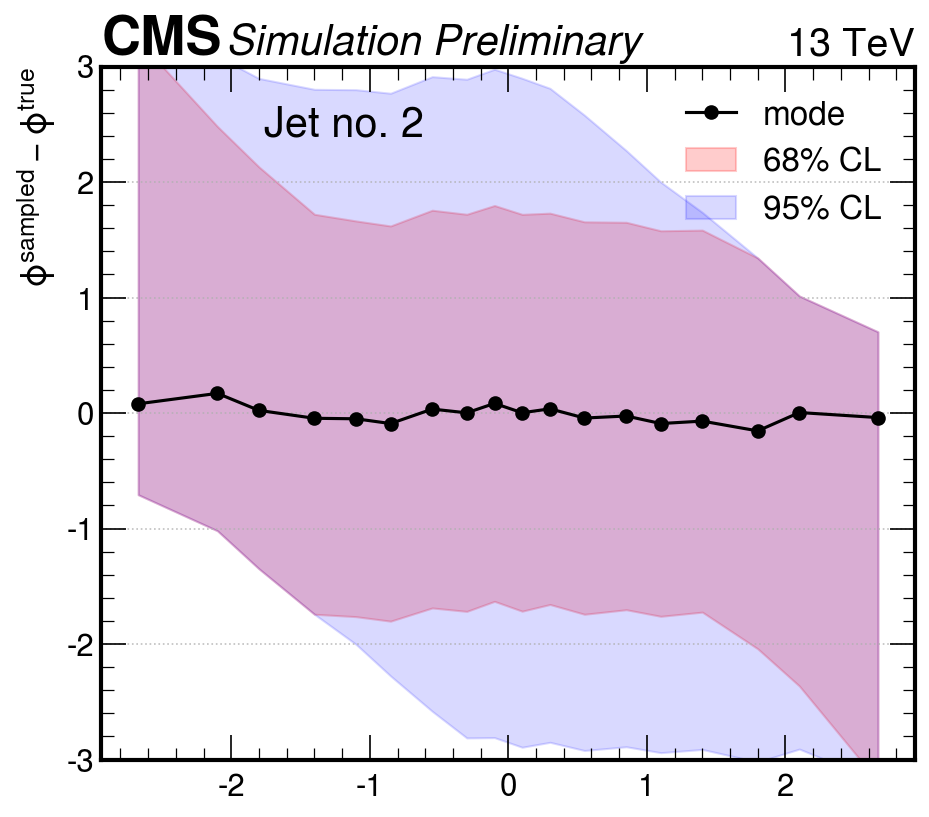

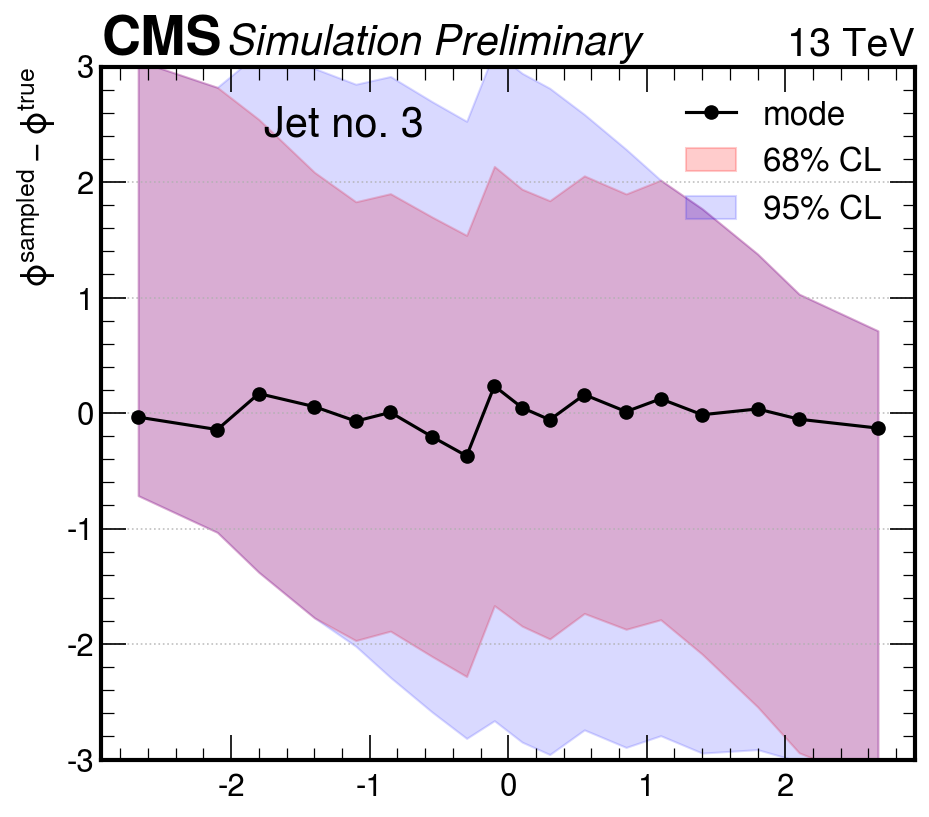

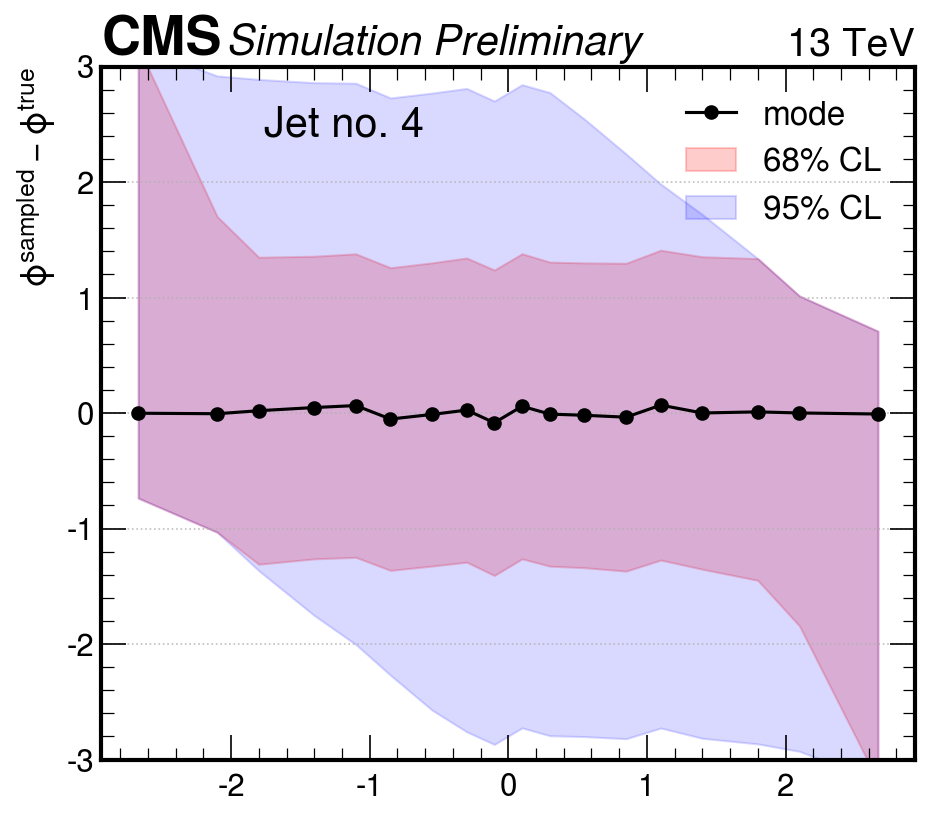

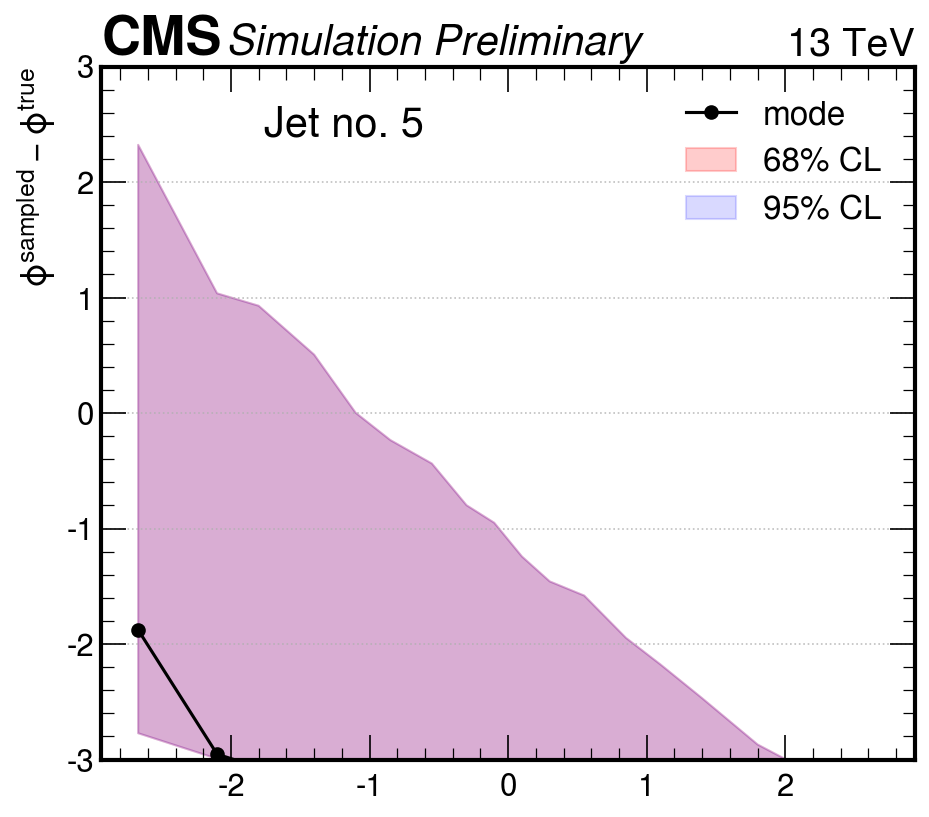

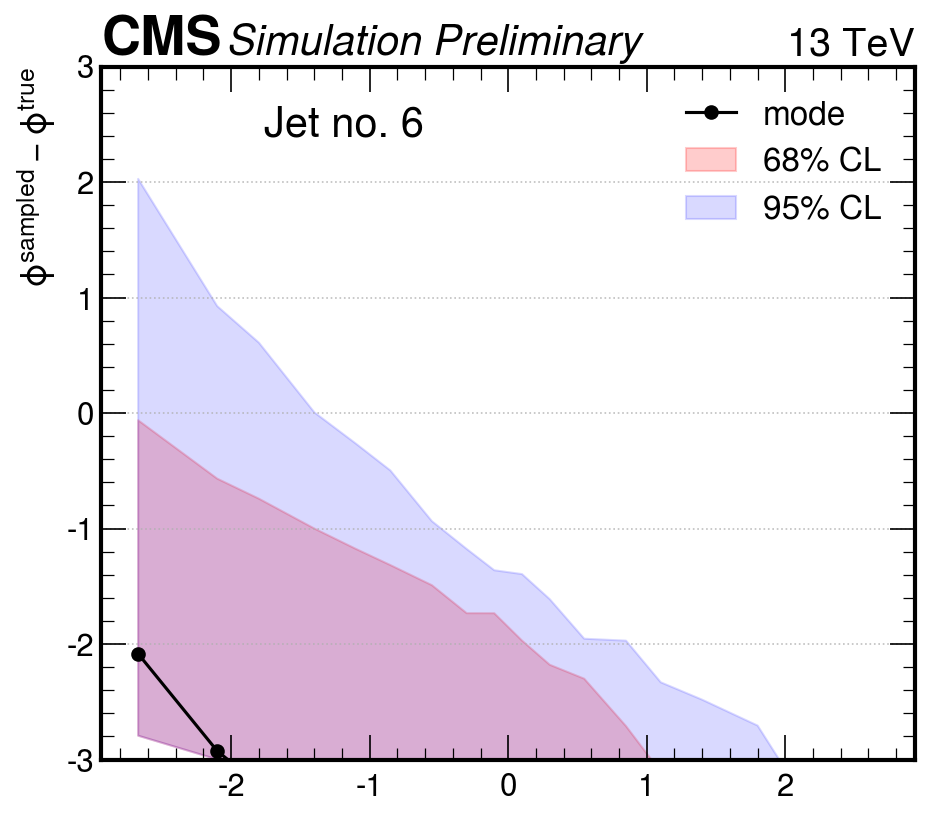

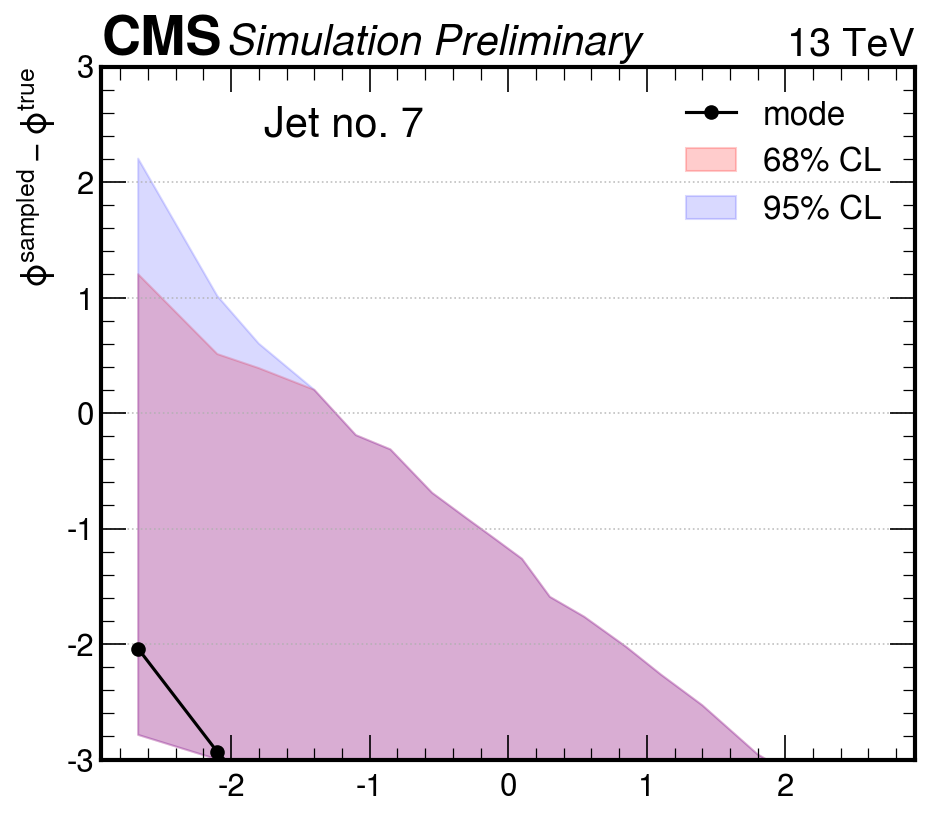

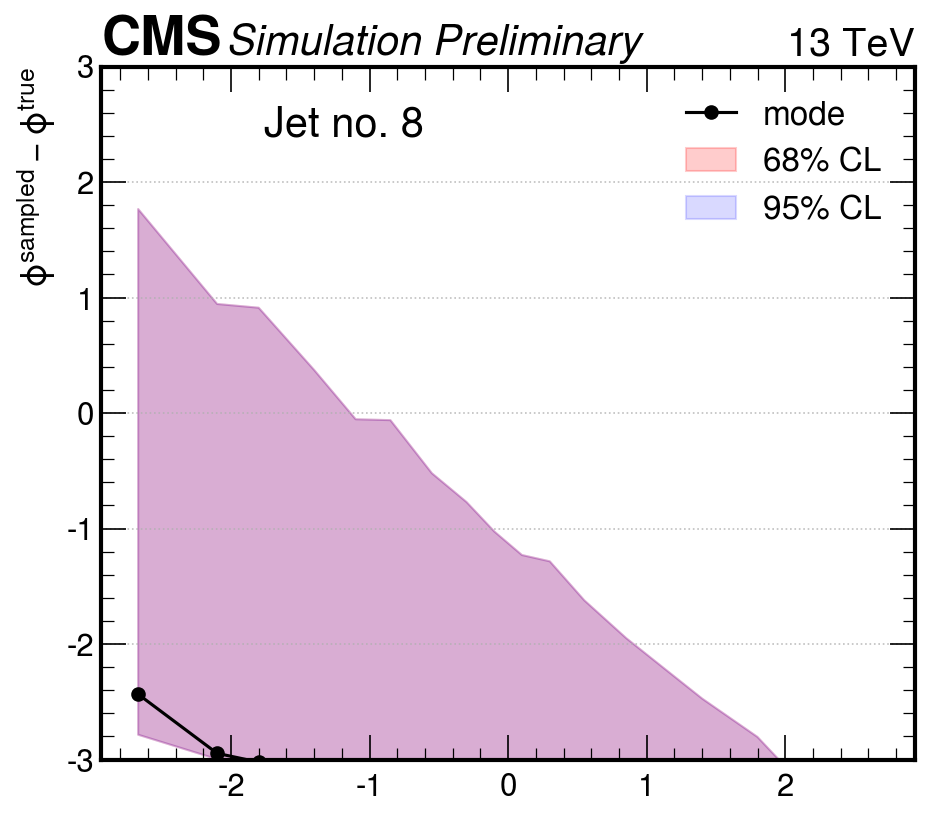

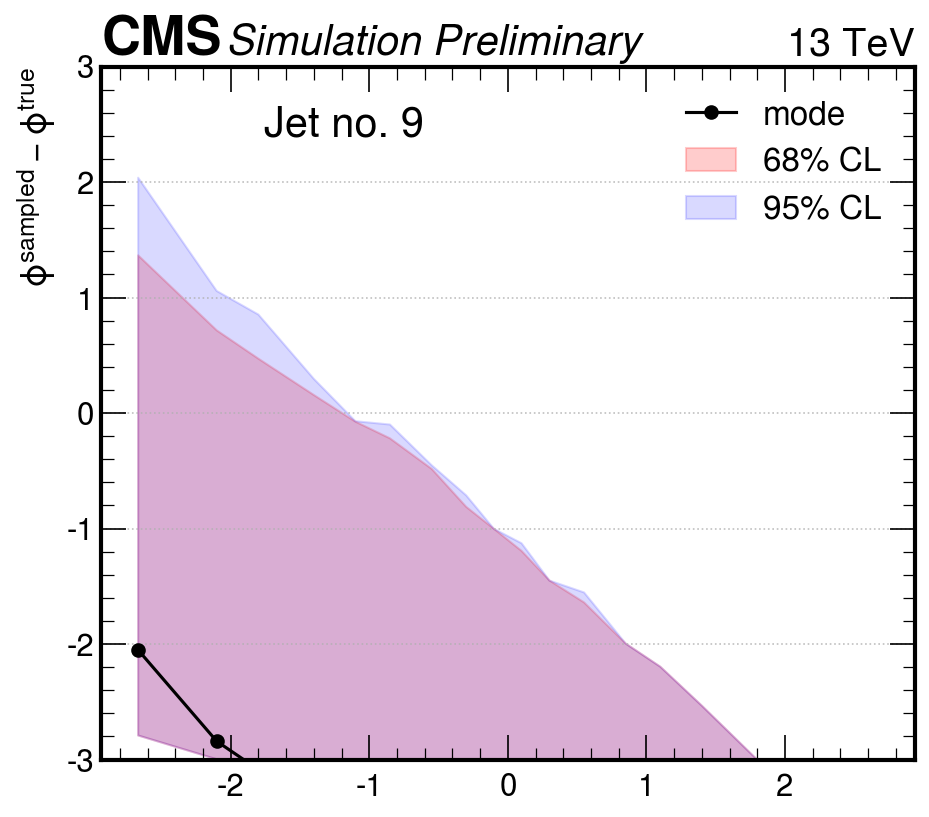

In [40]:
No_samples = 30
print(sampledAllEvent.size(0))

for jet in range(12):

    diff_phi = sampledAllEvent[:,1:,jet,2] - sampledAllEvent[:,0,jet,2].unsqueeze(dim=1) # sampled - target
    diff_phi_flat = torch.flatten(diff_phi)
    #print(diff_eta[1,0])
    #print(diff_eta[1,1])
    #print(sampledAllEvent[1,0,jet,1])

    targetPhiRepeated = sampledAllEvent[:,0,jet,2].repeat_interleave(No_samples)

    #print()
    #print(diff_eta_flat[30])
    #print(diff_eta_flat[31])
    #print(targetRepeated[30])
    #print(targetRepeated[31])
    
    plot_diff_mode_quantile(diff_phi_flat.numpy(), 
                            X=targetPhiRepeated.numpy(),  
                            cat_var=targetPhiRepeated.numpy(), 
                            bins=[-3.14,-2.2,-2.,-1.6, -1.2, -1.0, 
                                   -0.7, -0.4, -0.2, -0., 0.2,0.4, 0.7,
                                   1., 1.2, 1.6, 2., 2.2, 3.14],
                            xlabel='', ylim=(-3,3),
                            ylabel='$\phi^{sampled} - \phi^{true}$', title=f'Jet no. {jet}',nbins_mode=50)


In [ ]:
No_samples = 30
print(sampledAllEvent.size(0))

for jet in range(12):

    ratio_pt = sampledAllEvent[:,1:,jet,0]/sampledAllEvent[:,0,jet,0].unsqueeze(dim=1) # sampled - target
    ratio_pt_flat = torch.flatten(ratio_pt)
    #print(diff_eta[1,0])
    #print(diff_eta[1,1])
    #print(sampledAllEvent[1,0,jet,1])

    targetPtRepeated = sampledAllEvent[:,0,jet,0].repeat_interleave(No_samples)

    #print()
    #print(diff_eta_flat[30])
    #print(diff_eta_flat[31])
    #print(targetRepeated[30])
    #print(targetRepeated[31])
    
    plot_diff_mode_quantile(ratio_pt_flat.numpy(), 
                            X=targetPtRepeated.numpy(),  
                            cat_var=targetPtRepeated.numpy(), 
                            bins=[0,50,100,150,200,300,400,600,1000], 
                            xlabel='', ylim=(-3,3),
                            ylabel='$pt^{sampled}/pt^{true}$', title=f'Jet no. {jet}',nbins_mode=50)
